# Elastic Net Regression Volatility

[*********************100%***********************]  1 of 1 completed


Processing F...

Fitting 5 folds for each of 50 candidates, totalling 250 fits


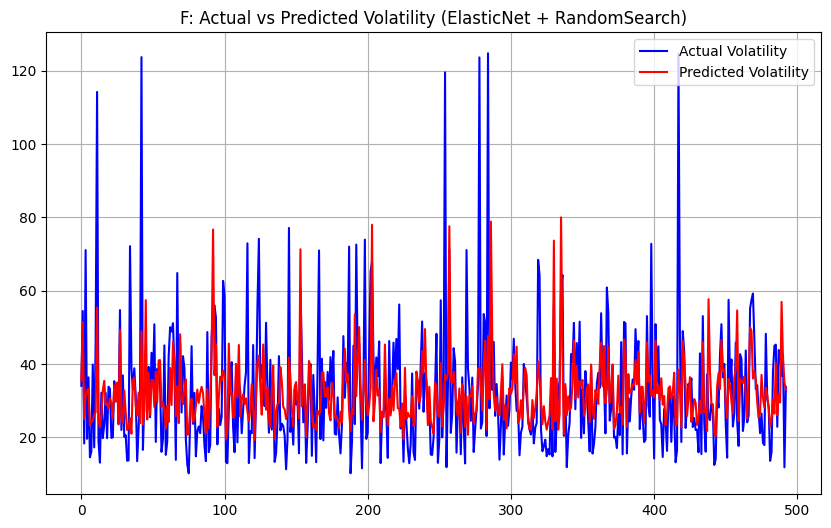

[*********************100%***********************]  1 of 1 completed


Processing CAT...

Fitting 5 folds for each of 50 candidates, totalling 250 fits


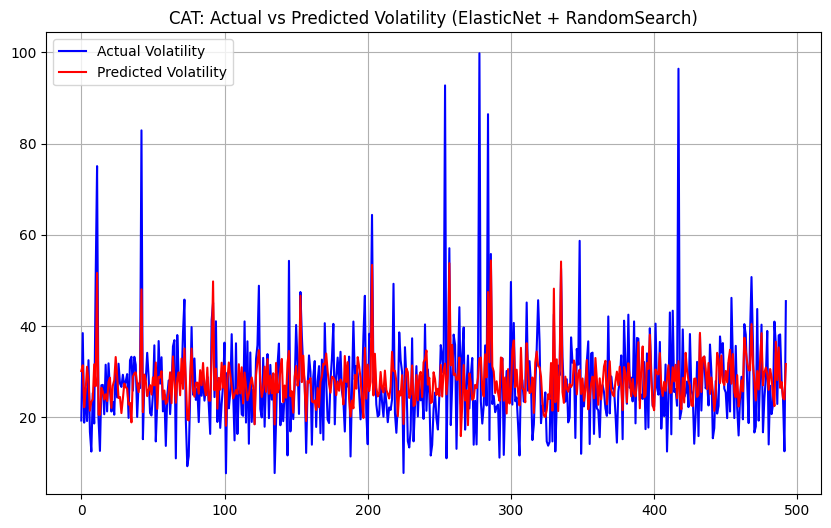


Processing DE...



[*********************100%***********************]  1 of 1 completed


Fitting 5 folds for each of 50 candidates, totalling 250 fits


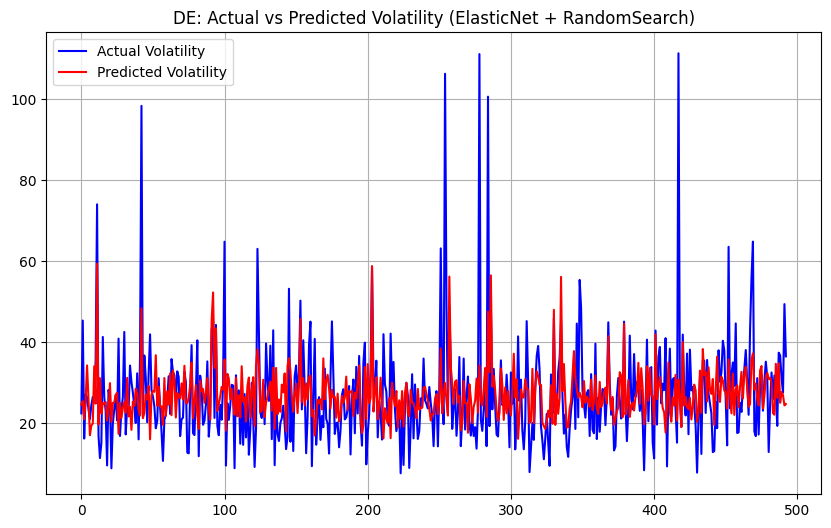


Processing AAPL...



[*********************100%***********************]  1 of 1 completed


Fitting 5 folds for each of 50 candidates, totalling 250 fits


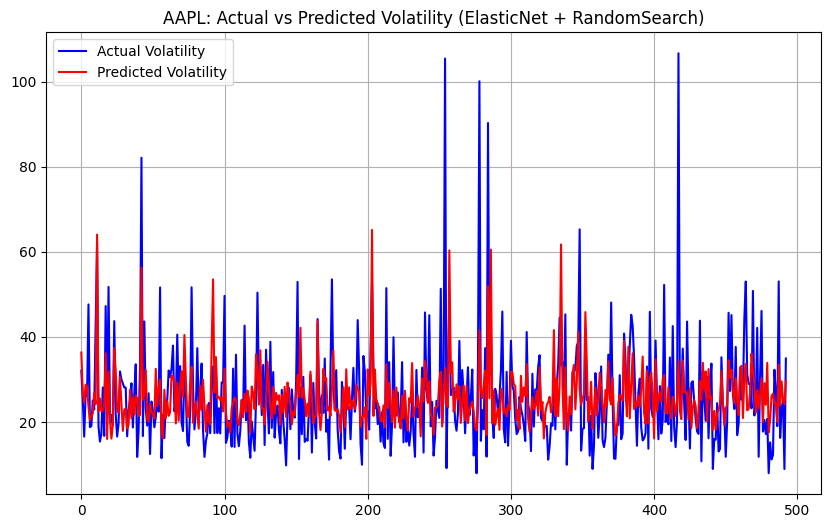

[*********************100%***********************]  1 of 1 completed


Processing WHR...

Fitting 5 folds for each of 50 candidates, totalling 250 fits


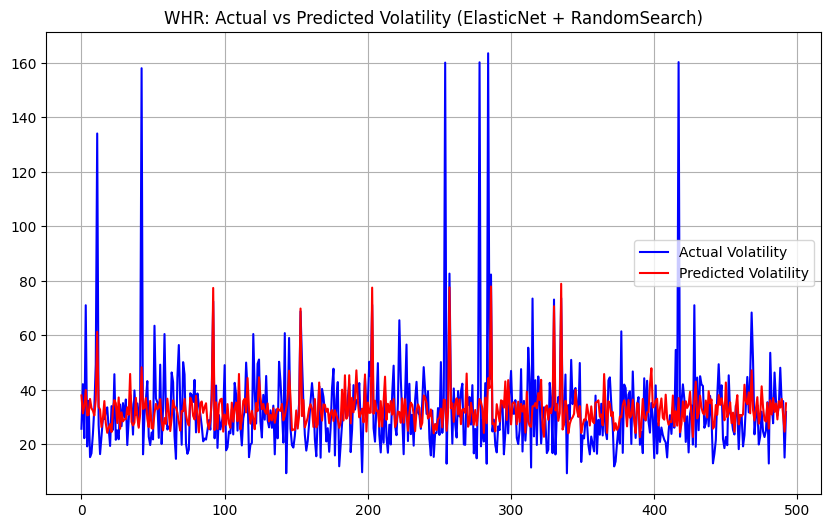

[*********************100%***********************]  1 of 1 completed


Processing X...

Fitting 5 folds for each of 50 candidates, totalling 250 fits


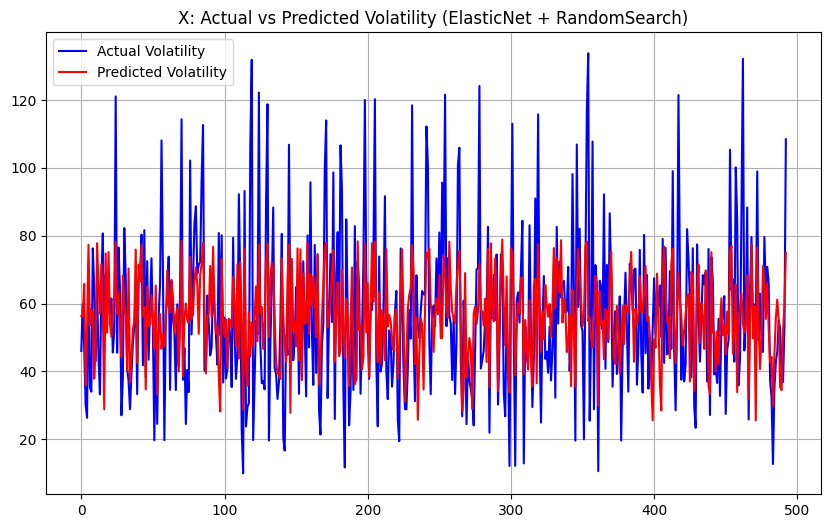

[*********************100%***********************]  1 of 1 completed


Processing CF...

Fitting 5 folds for each of 50 candidates, totalling 250 fits


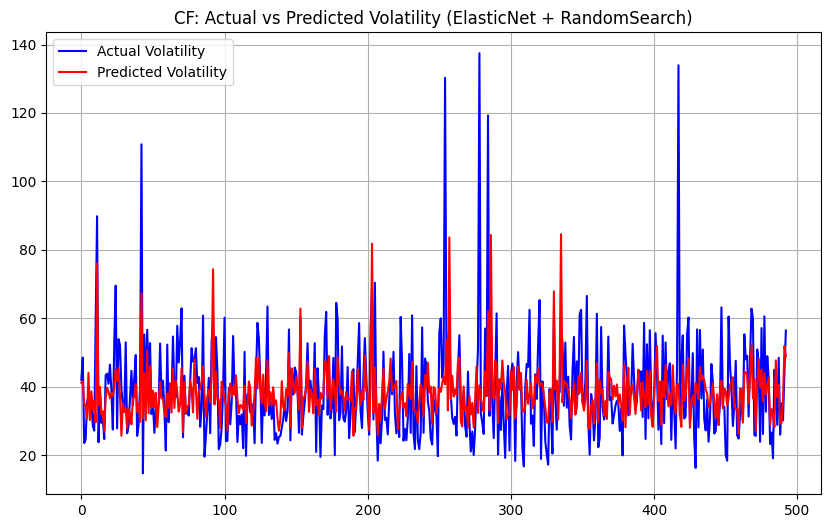

[*********************100%***********************]  1 of 1 completed


Processing VLO...

Fitting 5 folds for each of 50 candidates, totalling 250 fits


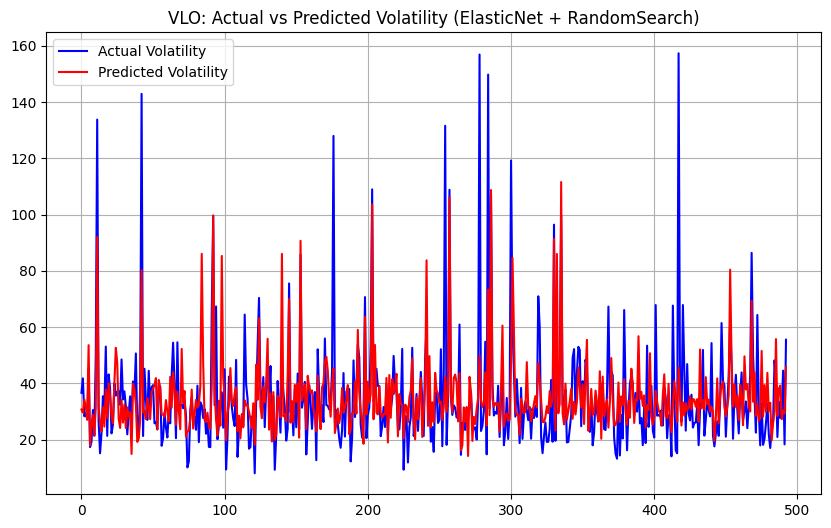

[*********************100%***********************]  1 of 1 completed


Processing TGT...

Fitting 5 folds for each of 50 candidates, totalling 250 fits


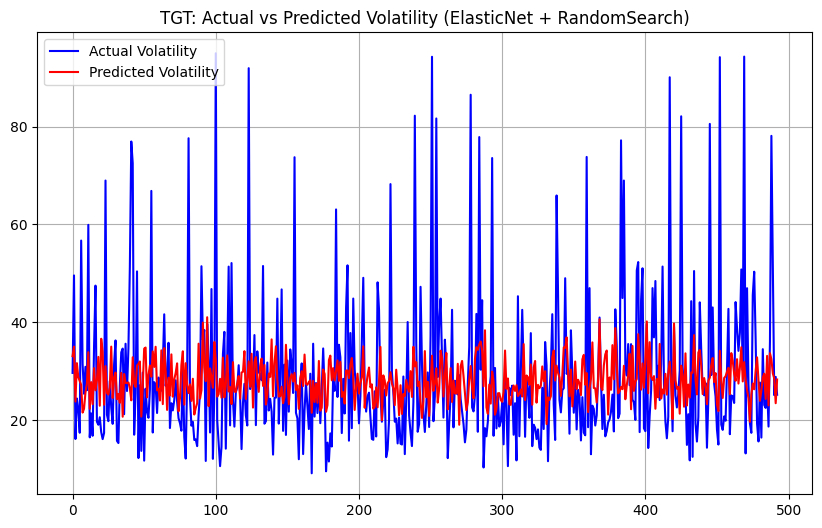

[*********************100%***********************]  1 of 1 completed


Processing DG...

Fitting 5 folds for each of 50 candidates, totalling 250 fits


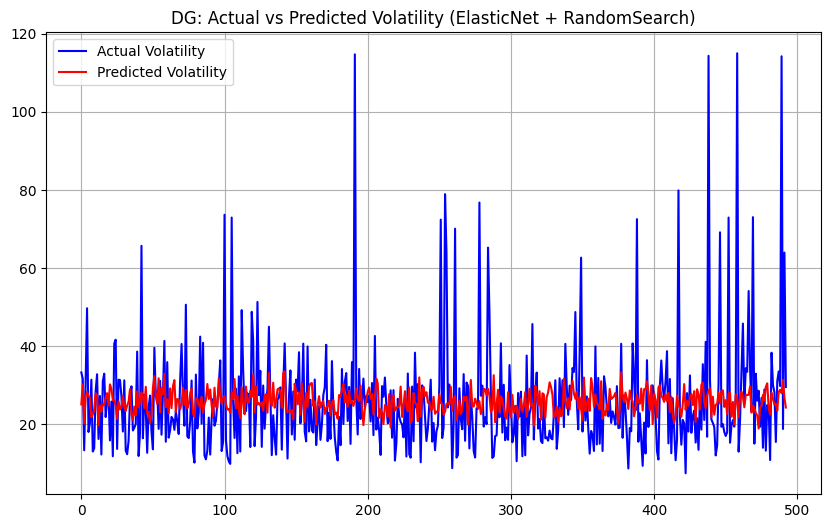


ElasticNet + RandomSearch Model Results:
  Ticker       RMSE  Relative RMSE (%)  R_squared  \
1    CAT   9.622317          10.448299   0.275101   
3   AAPL  10.406225          10.542144   0.290327   
2     DE  11.274624          10.872902   0.238242   
6     CF  12.672649          10.319667   0.284220   
9     DG  14.272454          13.268711   0.022266   
0      F  14.496144          12.649258   0.281329   
8    TGT  14.893604          17.348814   0.067732   
7    VLO  15.265432          10.224730   0.407211   
4    WHR  16.580050          10.755412   0.181144   
5      X  19.918161          16.084605   0.280440   

                                         Best_Params  
1  {'l1_ratio': 0.6565656565656566, 'alpha': 1.35...  
3  {'l1_ratio': 0.05050505050505051, 'alpha': 0.0...  
2  {'l1_ratio': 0.05050505050505051, 'alpha': 0.0...  
6  {'l1_ratio': 0.6565656565656566, 'alpha': 1.35...  
9  {'l1_ratio': 0.20202020202020204, 'alpha': 1.7...  
0  {'l1_ratio': 0.2828282828282829, 'alpha':

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from ta.momentum import RSIIndicator
from ta.trend import MACD

# List of tickers
tickers = ['F', 'CAT', 'DE', 'AAPL', 'WHR', 'X', 'CF', 'VLO', 'TGT', 'DG']


# Create an empty list to store results
results = []

# Define parameter distributions for ElasticNet
param_distributions = {
    'alpha': np.logspace(-3, 2, 100),   # 0.001 to 100 (log scale)
    'l1_ratio': np.linspace(0, 1, 100)  # 0 to 1 (mix of L1 and L2)
}

for ticker in tickers:
    print(f"\nProcessing {ticker}...\n")
    
    # Download historical stock data
    data = yf.download(ticker, start="2015-01-01", end="2025-01-01", group_by="ticker")
    
    # Flatten the multiindex columns
    data.columns = ['_'.join(col).strip() for col in data.columns.values]
    
    # Calculate daily returns
    data['Returns'] = data[f'{ticker}_Close'].pct_change()
    
    # Drop NaN values
    data.dropna(inplace=True)
    
    # Calculate historical volatility (21 days window, annualized and in %)
    window = 21
    data['Volatility'] = data['Returns'].rolling(window=window).std() * np.sqrt(252) * 100
    
    # Feature engineering
    data['MA_21'] = data[f'{ticker}_Close'].rolling(window=21).mean()
    
    rsi = RSIIndicator(close=data[f'{ticker}_Close'], window=14)
    data['RSI'] = rsi.rsi()
    
    macd = MACD(close=data[f'{ticker}_Close'])
    data['MACD'] = macd.macd_diff()
    
    # Rename columns for consistency
    data = data.rename(columns={
        f'{ticker}_Open': 'Open',
        f'{ticker}_High': 'High',
        f'{ticker}_Low': 'Low',
        f'{ticker}_Close': 'Close',
        f'{ticker}_Volume': 'Volume'
    })
    
    # Create target variable: future volatility 21 days ahead
    data['Future_Volatility'] = data['Volatility'].shift(-21)
    
    # Drop remaining NaNs
    data.dropna(inplace=True)
    
    # Features and target
    X = data[['MA_21', 'RSI', 'MACD', 'Volatility']]
    y = data['Future_Volatility']
    
    # Split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Instantiate ElasticNet
    elastic_net = ElasticNet(random_state=42, max_iter=50000)
    
    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=elastic_net,
        param_distributions=param_distributions,
        n_iter=50,  # Try 50 random combinations
        cv=5,
        scoring='r2',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    random_search.fit(X_train, y_train)
    
    # Get the best model and best parameters
    elastic_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    # Make predictions
    y_pred = elastic_model.predict(X_test)
    
    # Plot Actual vs Predicted
    plt.figure(figsize=(10,6))
    plt.plot(y_test.values, label='Actual Volatility', color='blue')
    plt.plot(y_pred, label='Predicted Volatility', color='red')
    plt.title(f'{ticker}: Actual vs Predicted Volatility (ElasticNet + RandomSearch)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return_range = y_test.max() - y_test.min()
    relative_rmse = rmse / return_range * 100  # percentage

    # Save result for this ticker
    results.append({
        'Ticker': ticker,
        'RMSE': rmse,
        'Relative RMSE (%)': relative_rmse,
        'R_squared': r2,
        'Best_Params': best_params
    })

# Convert results to a DataFrame
results_elastic = pd.DataFrame(results)

# Sort by RMSE
results_elastic = results_elastic.sort_values('RMSE')

# Display results
print("\nElasticNet + RandomSearch Model Results:")
print(results_elastic)


# Random Forest Regression Volatilieit

[*********************100%***********************]  1 of 1 completed


Processing F...



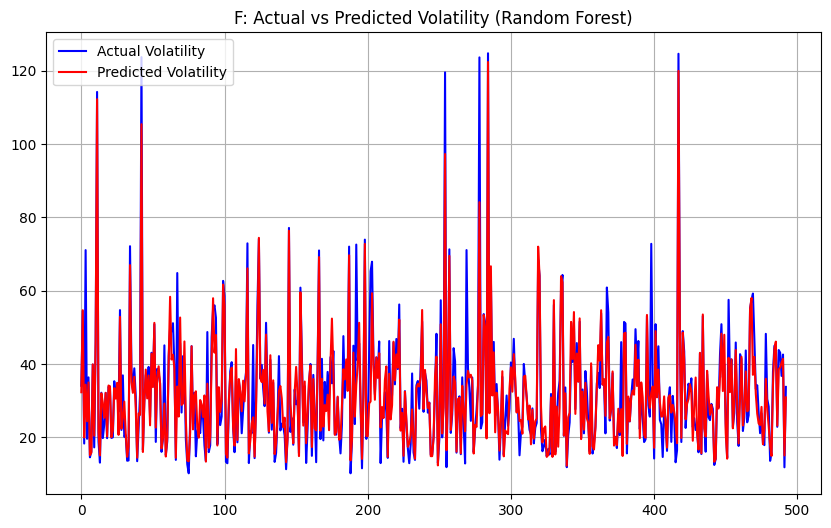

[*********************100%***********************]  1 of 1 completed


Processing CAT...



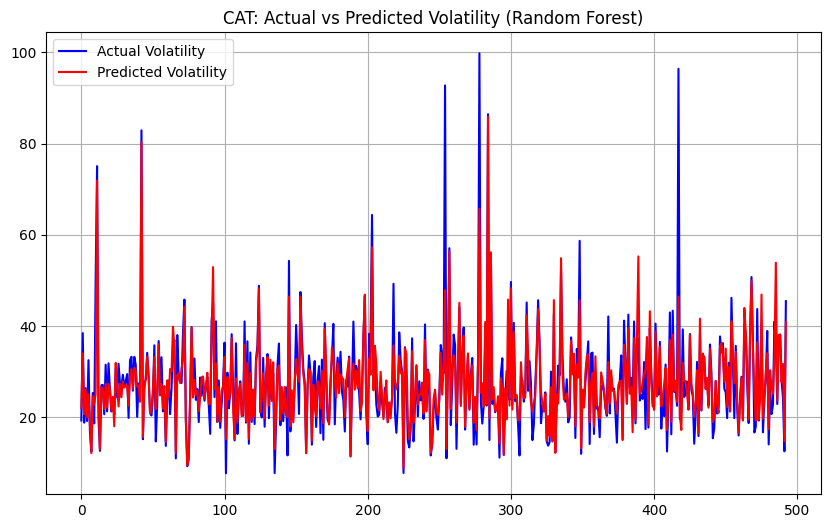

[*********************100%***********************]  1 of 1 completed


Processing DE...



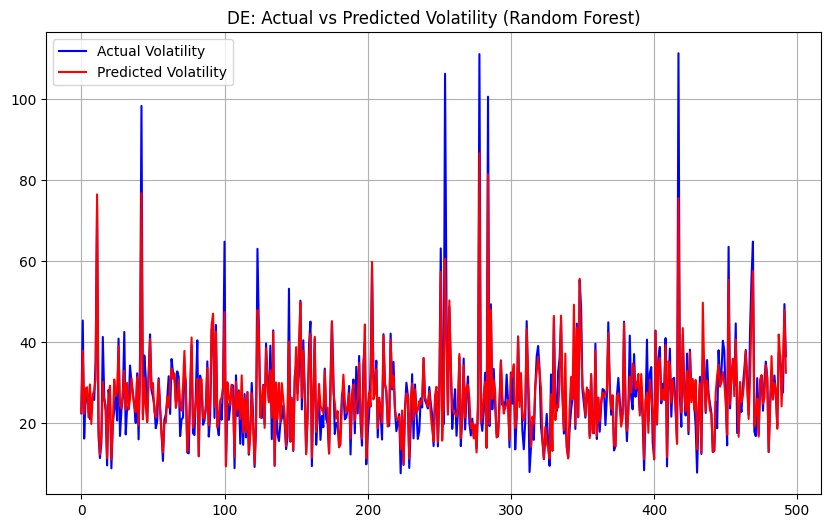

[*********************100%***********************]  1 of 1 completed


Processing AAPL...



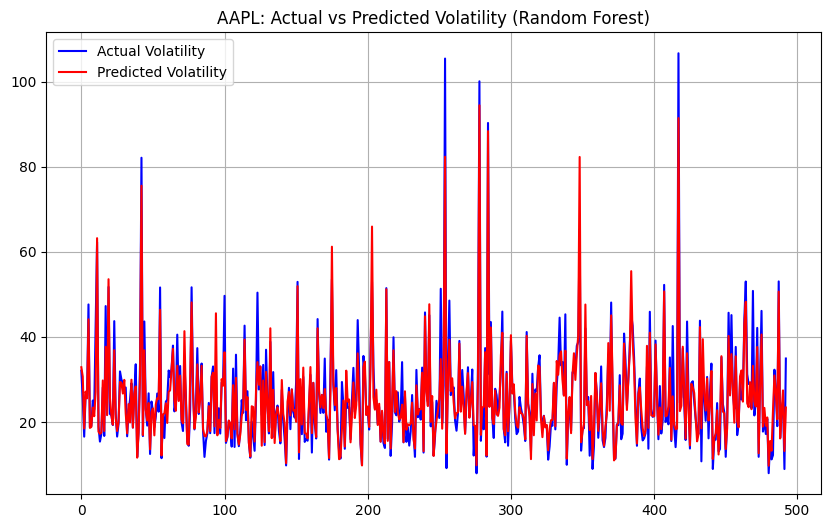

[*********************100%***********************]  1 of 1 completed


Processing WHR...



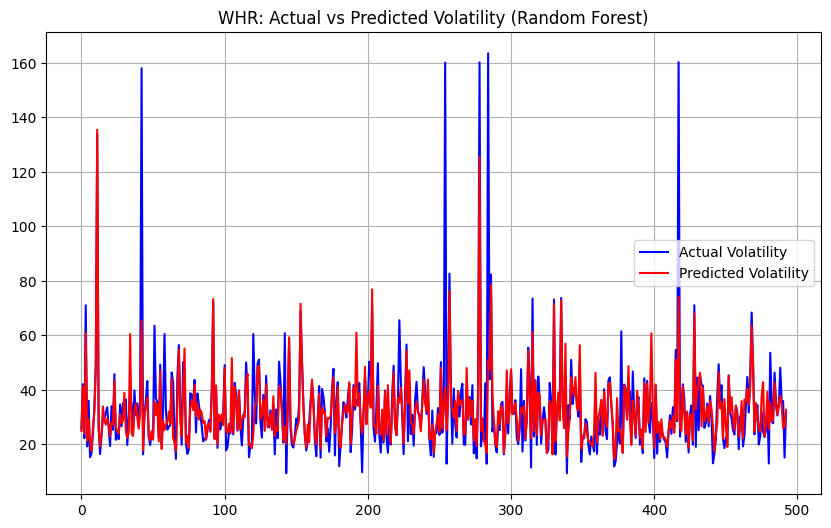

[*********************100%***********************]  1 of 1 completed


Processing X...



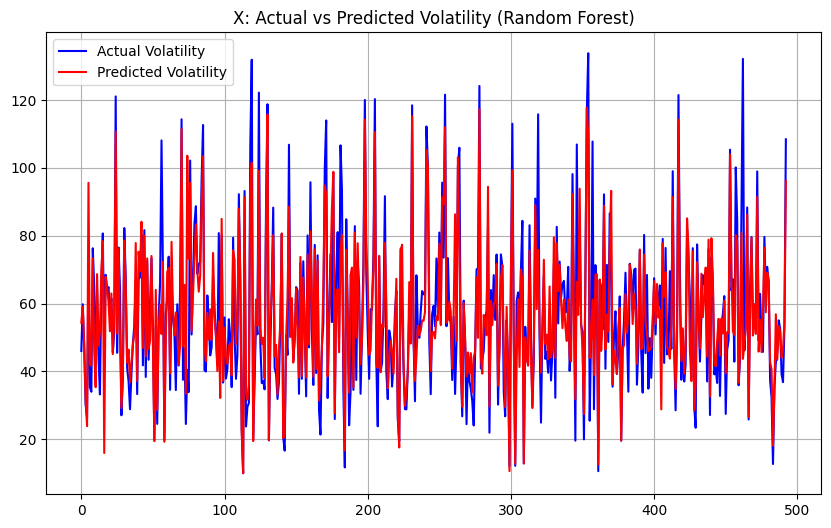

[*********************100%***********************]  1 of 1 completed


Processing CF...



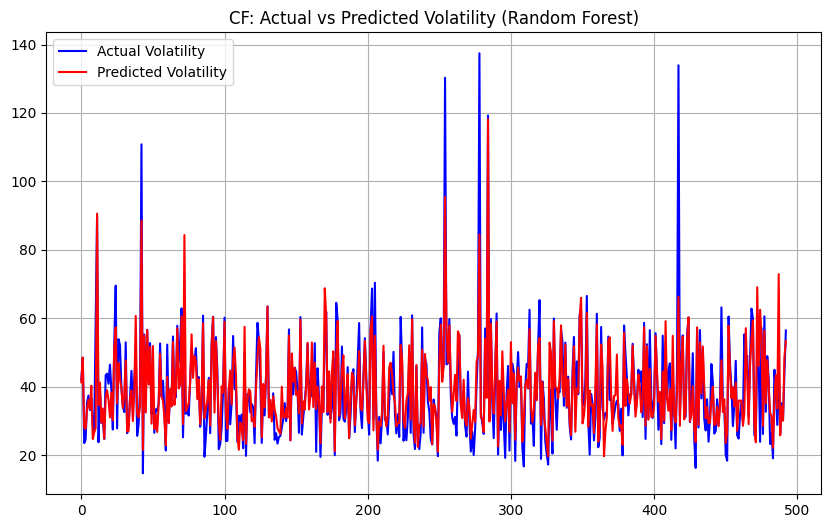

[*********************100%***********************]  1 of 1 completed


Processing VLO...



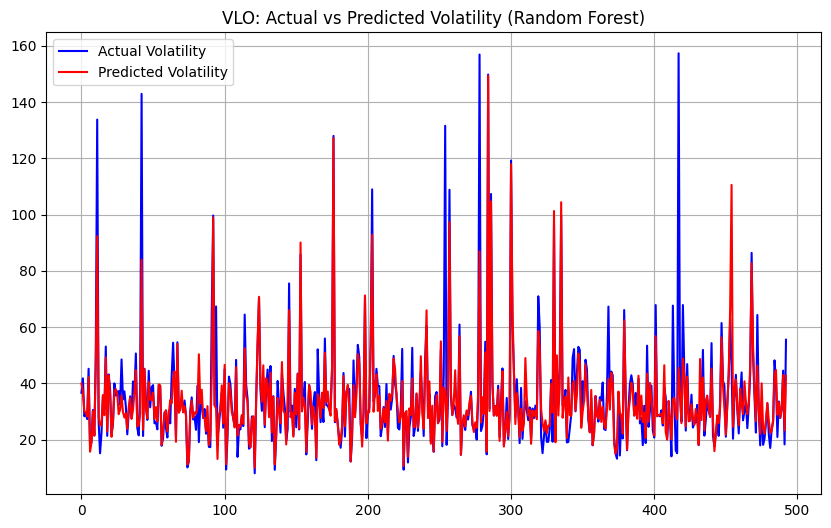

[*********************100%***********************]  1 of 1 completed


Processing TGT...



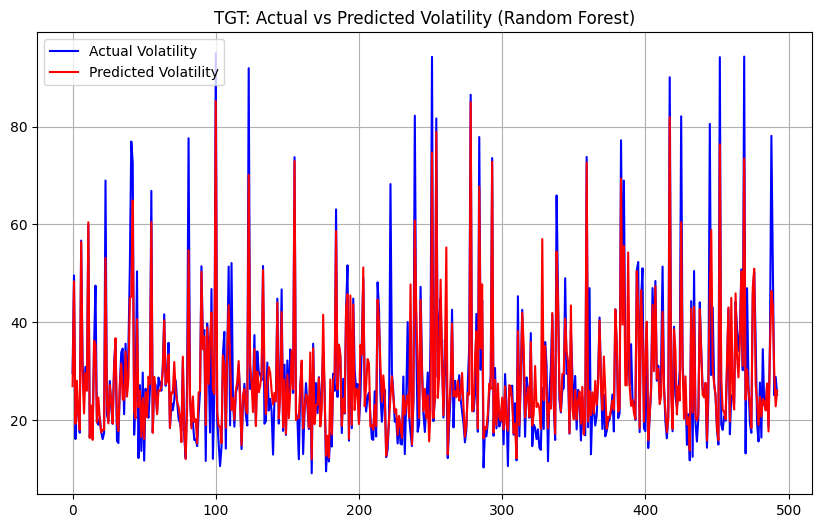

[*********************100%***********************]  1 of 1 completed


Processing DG...



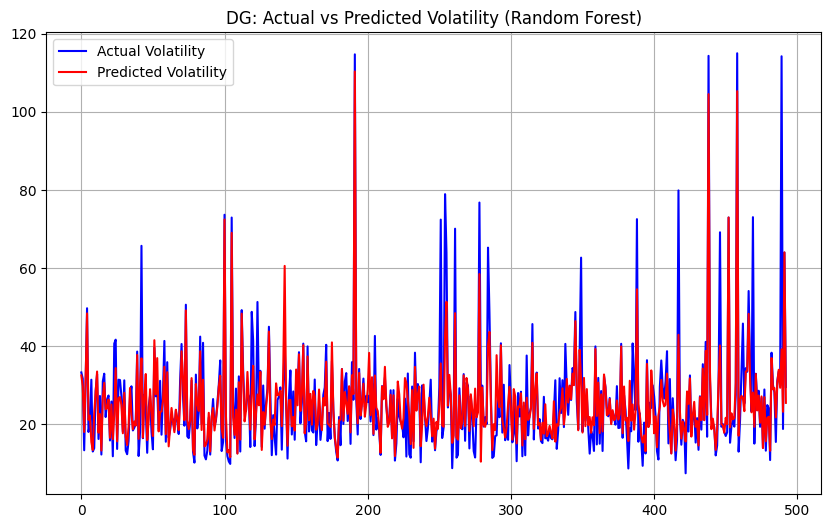


Random Forest Model Results:
  Ticker       RMSE  Relative RMSE (%)  R_squared
3   AAPL   3.939753           3.991211   0.898279
2     DE   5.189518           5.004613   0.838614
1    CAT   5.240798           5.690669   0.784963
0      F   6.501560           5.673227   0.855436
8    TGT   6.933780           8.076814   0.797939
9     DG   7.532619           7.002870   0.727657
6     CF   7.799187           6.351081   0.728891
7    VLO  10.218103           6.844048   0.734403
5      X  11.210770           9.053085   0.772050
4    WHR  11.664559           7.566753   0.594704


In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from ta.momentum import RSIIndicator
from ta.trend import MACD

# List of tickers
tickers = ['F', 'CAT', 'DE', 'AAPL', 'WHR', 'X', 'CF', 'VLO', 'TGT', 'DG']


# Create an empty list to store results
results = []

for ticker in tickers:
    print(f"\nProcessing {ticker}...\n")
    
    # Download historical stock data
    data = yf.download(ticker, start="2015-01-01", end="2025-01-01", group_by="ticker")
    
    # Flatten the multiindex columns
    data.columns = ['_'.join(col).strip() for col in data.columns.values]
    
    # Calculate daily returns
    data['Returns'] = data[f'{ticker}_Close'].pct_change()
    
    # Drop NaN values
    data.dropna(inplace=True)
    
    # Calculate historical volatility (21 days window, annualized and in %)
    window = 21
    data['Volatility'] = data['Returns'].rolling(window=window).std() * np.sqrt(252) * 100
    
    # Feature engineering
    data['MA_21'] = data[f'{ticker}_Close'].rolling(window=21).mean()
    
    rsi = RSIIndicator(close=data[f'{ticker}_Close'], window=14)
    data['RSI'] = rsi.rsi()
    
    macd = MACD(close=data[f'{ticker}_Close'])
    data['MACD'] = macd.macd_diff()
    
    # Rename columns for consistency
    data = data.rename(columns={
        f'{ticker}_Open': 'Open',
        f'{ticker}_High': 'High',
        f'{ticker}_Low': 'Low',
        f'{ticker}_Close': 'Close',
        f'{ticker}_Volume': 'Volume'
    })
    
    # Create target variable: future volatility 21 days ahead
    data['Future_Volatility'] = data['Volatility'].shift(-21)
    
    # Drop remaining NaNs
    data.dropna(inplace=True)
    
    # Features and target
    X = data[['MA_21', 'RSI', 'MACD', 'Volatility']]
    y = data['Future_Volatility']
    
    # Split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Predict
    y_pred = rf_model.predict(X_test)
    
    # Plot Actual vs Predicted
    plt.figure(figsize=(10,6))
    plt.plot(y_test.values, label='Actual Volatility', color='blue')
    plt.plot(y_pred, label='Predicted Volatility', color='red')
    plt.title(f'{ticker}: Actual vs Predicted Volatility (Random Forest)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return_range = y_test.max() - y_test.min()
    relative_rmse = rmse / return_range * 100  # percentage

    # Save result for this ticker
    results.append({
        'Ticker': ticker,
        'RMSE': rmse,
        'Relative RMSE (%)': relative_rmse,
        'R_squared': r2
    })

# Convert results to a DataFrame
results_rf = pd.DataFrame(results)

# Sort by RMSE if you like
results_rf = results_rf.sort_values('RMSE')

# Display results
print("\nRandom Forest Model Results:")
print(results_rf)


# XGboost (gradient boosting model) Volatility

[*********************100%***********************]  1 of 1 completed


Processing F...



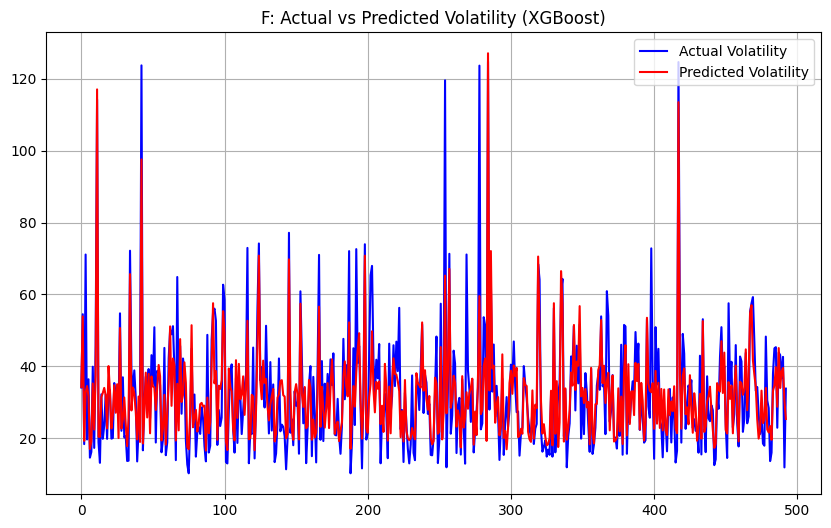

[*********************100%***********************]  1 of 1 completed


Processing CAT...



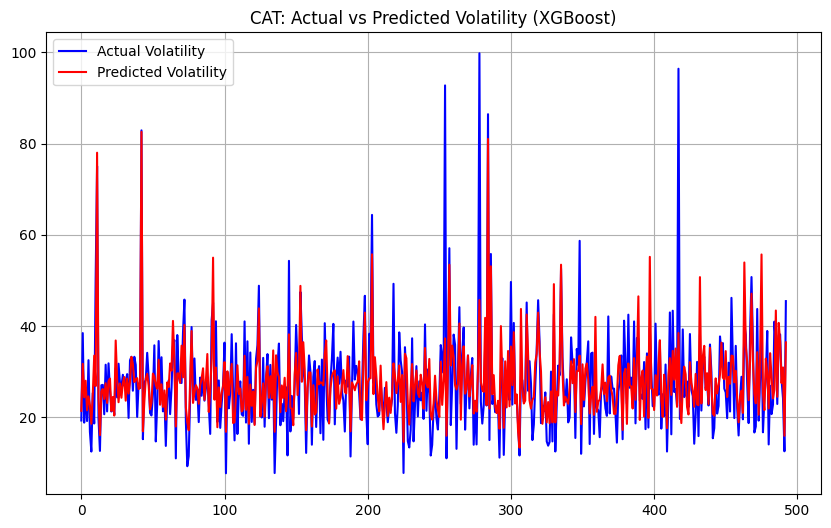

[*********************100%***********************]  1 of 1 completed


Processing DE...



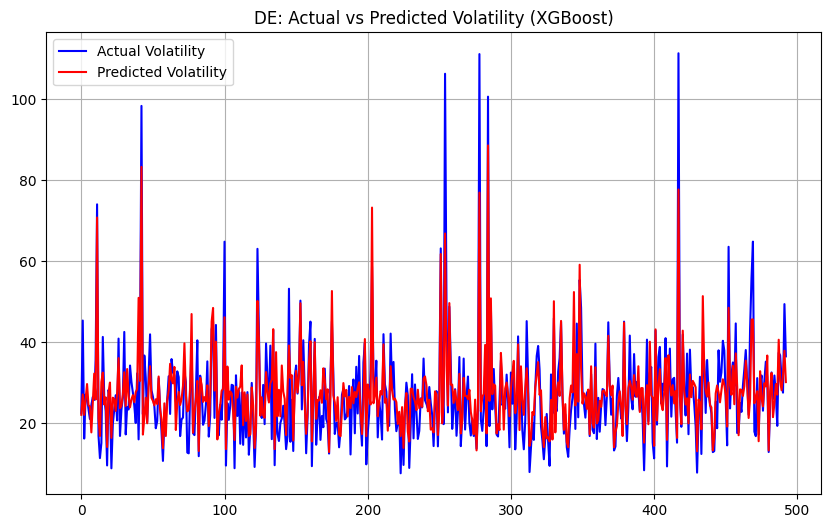

[*********************100%***********************]  1 of 1 completed


Processing AAPL...



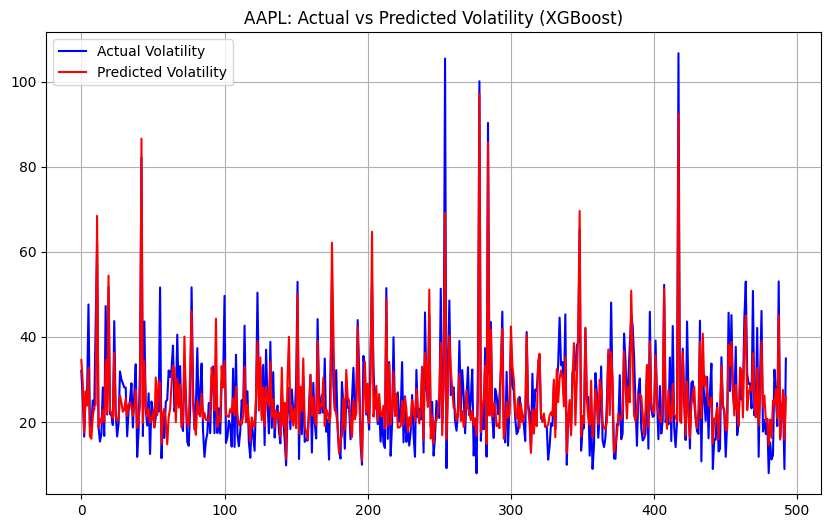

[*********************100%***********************]  1 of 1 completed


Processing WHR...



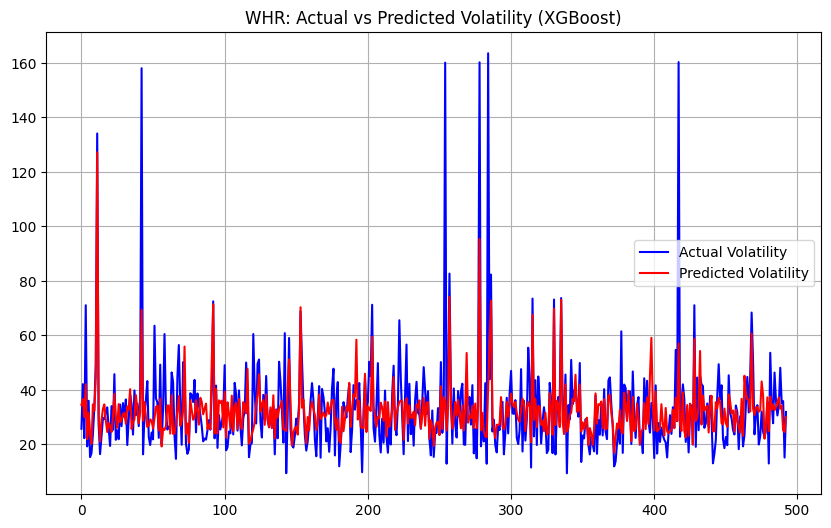


Processing X...



[*********************100%***********************]  1 of 1 completed


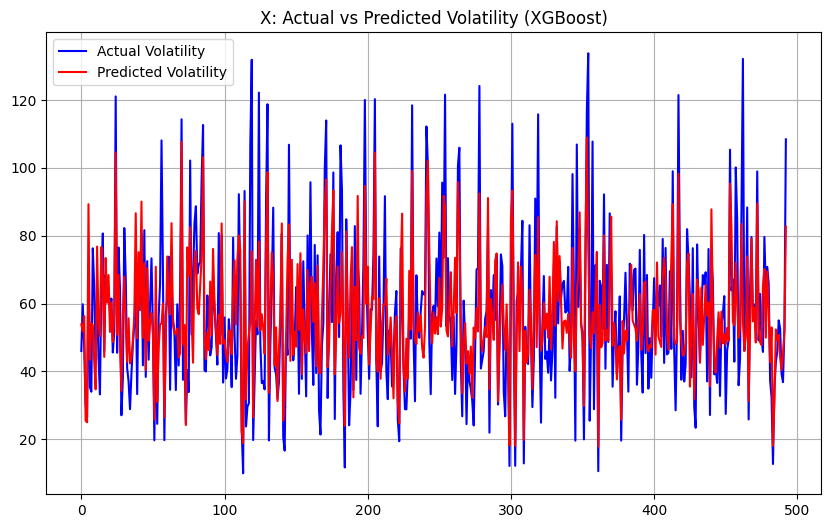

[*********************100%***********************]  1 of 1 completed


Processing CF...



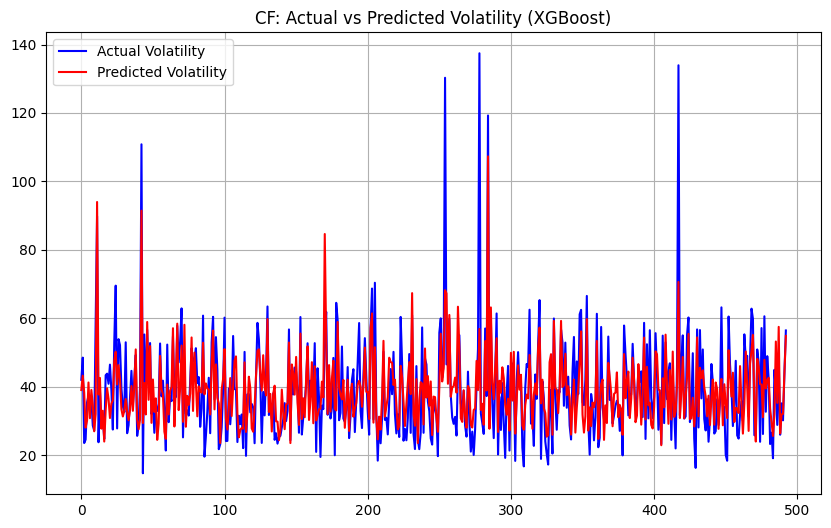

[*********************100%***********************]  1 of 1 completed


Processing VLO...



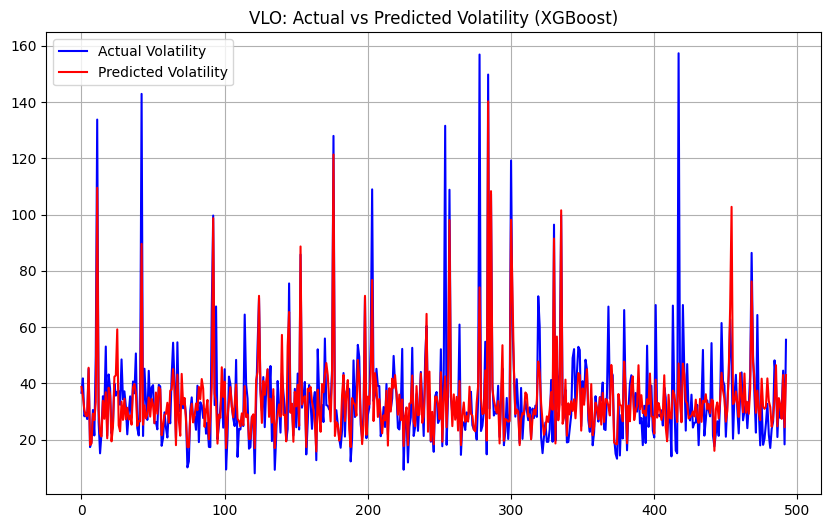

[*********************100%***********************]  1 of 1 completed


Processing TGT...



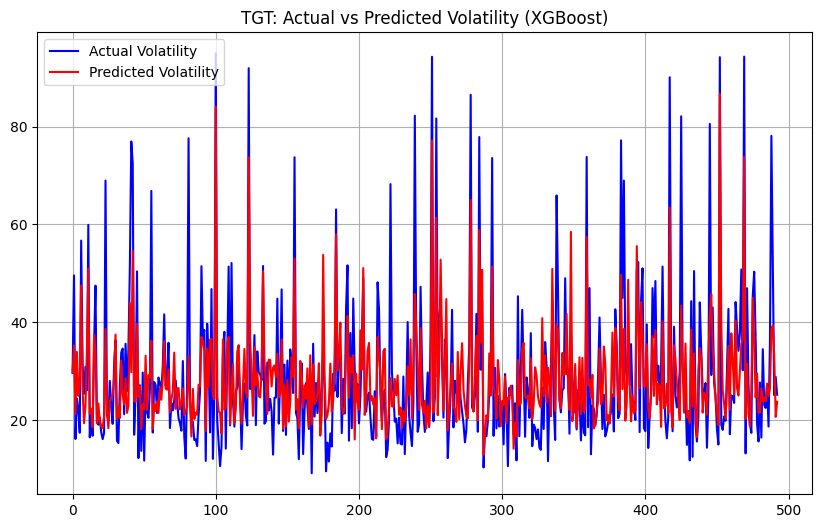

[*********************100%***********************]  1 of 1 completed


Processing DG...



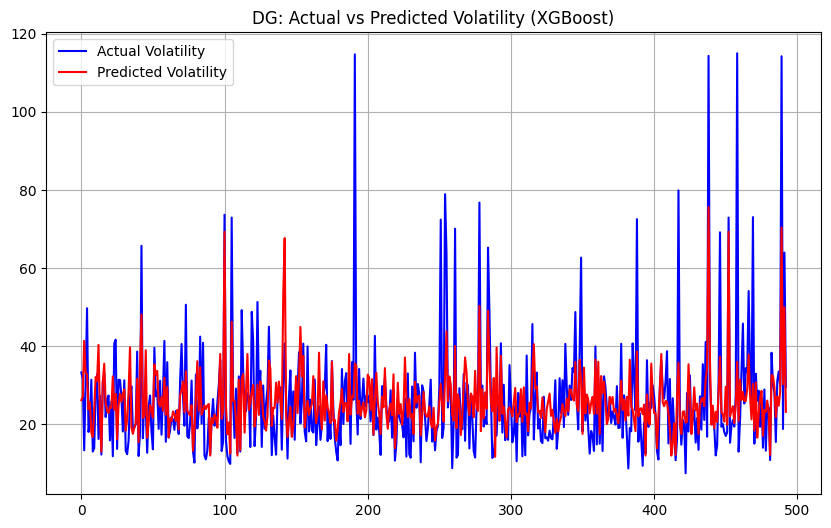


XGBoost + RandomSearch Model Results:
  Ticker       RMSE  Relative RMSE (%)  R_squared
3   AAPL   6.039136           6.118015   0.760987
2     DE   6.866796           6.622128   0.717433
1    CAT   7.521233           8.166858   0.557109
0      F   9.091594           7.933277   0.717313
8    TGT   9.759852          11.368763   0.599661
6     CF   9.871079           8.038276   0.565716
9     DG  11.070567          10.292003   0.411748
7    VLO  11.737136           7.861490   0.649566
4    WHR  13.700262           8.887305   0.440895
5      X  14.975276          12.093054   0.593259


In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from ta.momentum import RSIIndicator
from ta.trend import MACD

# List of tickers
tickers = ['F', 'CAT', 'DE', 'AAPL', 'WHR', 'X', 'CF', 'VLO', 'TGT', 'DG']


# Create an empty list to store results
results = []



for ticker in tickers:
    print(f"\nProcessing {ticker}...\n")
    
    # Download historical stock data
    data = yf.download(ticker, start="2015-01-01", end="2025-01-01", group_by="ticker")
    
    # Flatten the multiindex columns
    data.columns = ['_'.join(col).strip() for col in data.columns.values]
    
    # Calculate daily returns
    data['Returns'] = data[f'{ticker}_Close'].pct_change()
    
    # Drop NaN values
    data.dropna(inplace=True)
    
    # Calculate historical volatility (21 days window, annualized and in %)
    window = 21
    data['Volatility'] = data['Returns'].rolling(window=window).std() * np.sqrt(252) * 100
    
    # Feature engineering
    data['MA_21'] = data[f'{ticker}_Close'].rolling(window=21).mean()
    
    rsi = RSIIndicator(close=data[f'{ticker}_Close'], window=14)
    data['RSI'] = rsi.rsi()
    
    macd = MACD(close=data[f'{ticker}_Close'])
    data['MACD'] = macd.macd_diff()
    
    # Rename columns for consistency
    data = data.rename(columns={
        f'{ticker}_Open': 'Open',
        f'{ticker}_High': 'High',
        f'{ticker}_Low': 'Low',
        f'{ticker}_Close': 'Close',
        f'{ticker}_Volume': 'Volume'
    })
    
    # Create target variable: future volatility 21 days ahead
    data['Future_Volatility'] = data['Volatility'].shift(-21)
    
    # Drop remaining NaNs
    data.dropna(inplace=True)
    
    # Features and target
    X = data[['MA_21', 'RSI', 'MACD', 'Volatility']]
    y = data['Future_Volatility']
    
    # Split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # XGBoost Regressor
    XG_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    XG_model.fit(X_train, y_train)
    # Predict
    y_pred = XG_model.predict(X_test)
    
    # Plot Actual vs Predicted
    plt.figure(figsize=(10,6))
    plt.plot(y_test.values, label='Actual Volatility', color='blue')
    plt.plot(y_pred, label='Predicted Volatility', color='red')
    plt.title(f'{ticker}: Actual vs Predicted Volatility (XGBoost)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return_range = y_test.max() - y_test.min()
    relative_rmse = rmse / return_range * 100  # percentage

    # Save result for this ticker
    results.append({
        'Ticker': ticker,
        'RMSE': rmse,
        'Relative RMSE (%)': relative_rmse,
        'R_squared': r2
    })

# Convert results to a DataFrame
results_XG = pd.DataFrame(results)

# Sort by RMSE if you like
results_XG = results_XG.sort_values('RMSE')

# Display results
print("\nXGBoost + RandomSearch Model Results:")
print(results_XG)


# lightGBM (gradient boosting model) Volatiliteit

[*********************100%***********************]  1 of 1 completed


Processing F...

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1968, number of used features: 4
[LightGBM] [Info] Start training from score 32.304923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

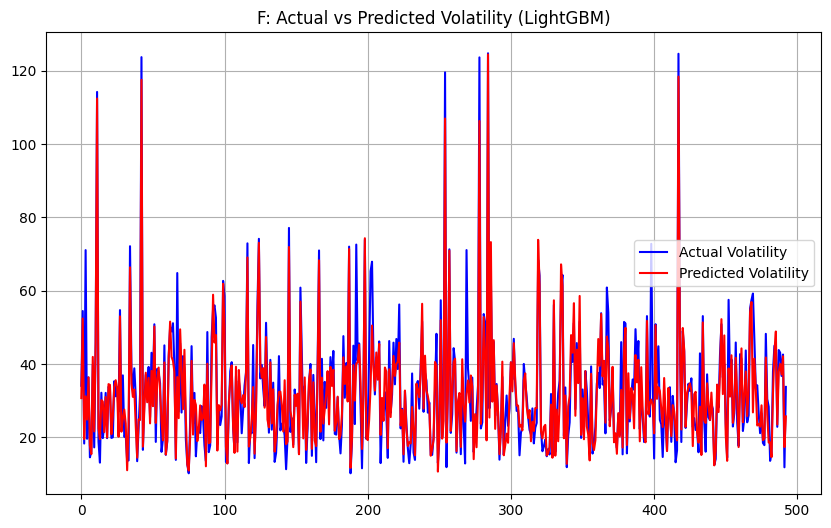

[*********************100%***********************]  1 of 1 completed


Processing CAT...

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1968, number of used features: 4
[LightGBM] [Info] Start training from score 27.862269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

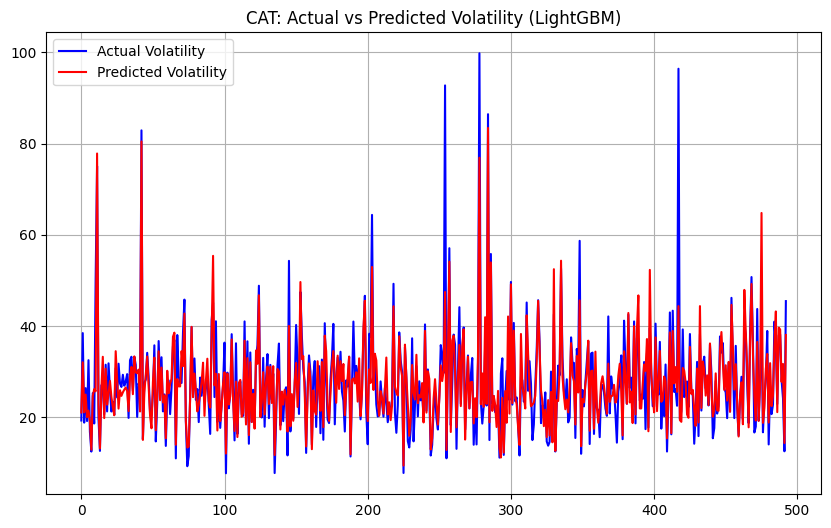

[*********************100%***********************]  1 of 1 completed


Processing DE...

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1968, number of used features: 4
[LightGBM] [Info] Start training from score 27.126909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

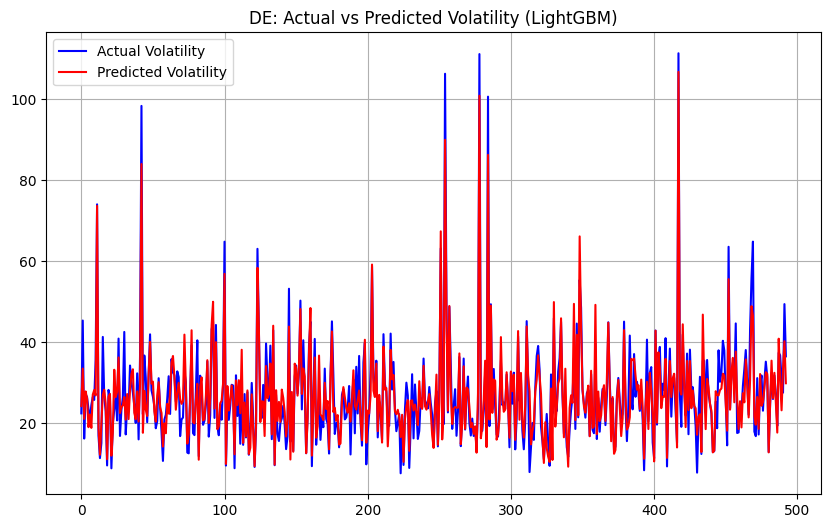


Processing AAPL...



[*********************100%***********************]  1 of 1 completed


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1968, number of used features: 4
[LightGBM] [Info] Start training from score 25.846601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

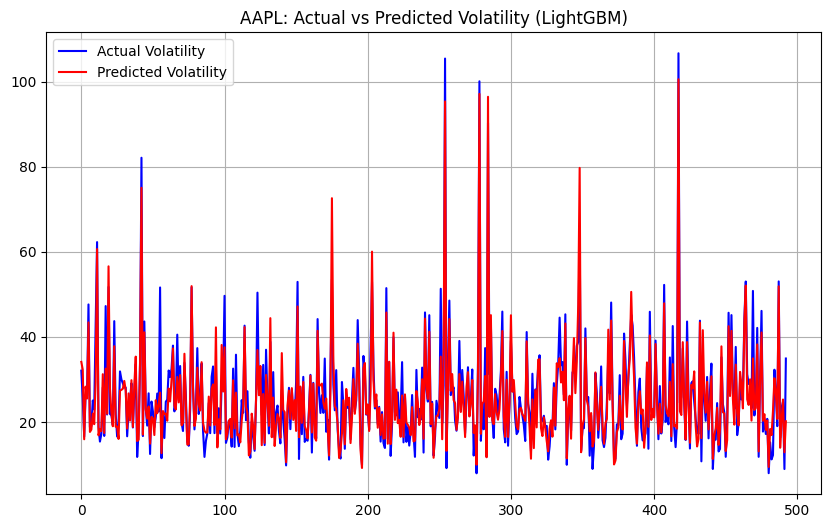

[*********************100%***********************]  1 of 1 completed


Processing WHR...

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1968, number of used features: 4
[LightGBM] [Info] Start training from score 32.430507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

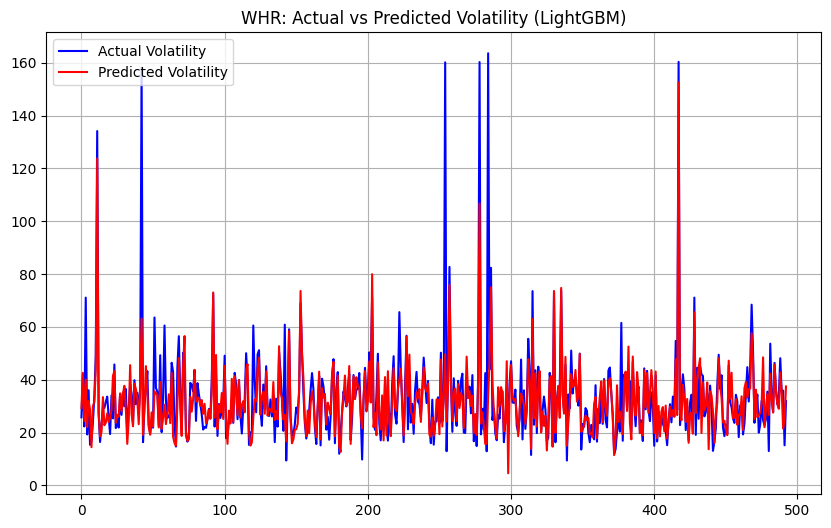

[*********************100%***********************]  1 of 1 completed


Processing X...



Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1968, number of used features: 4
[LightGBM] [Info] Start training from score 56.417353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

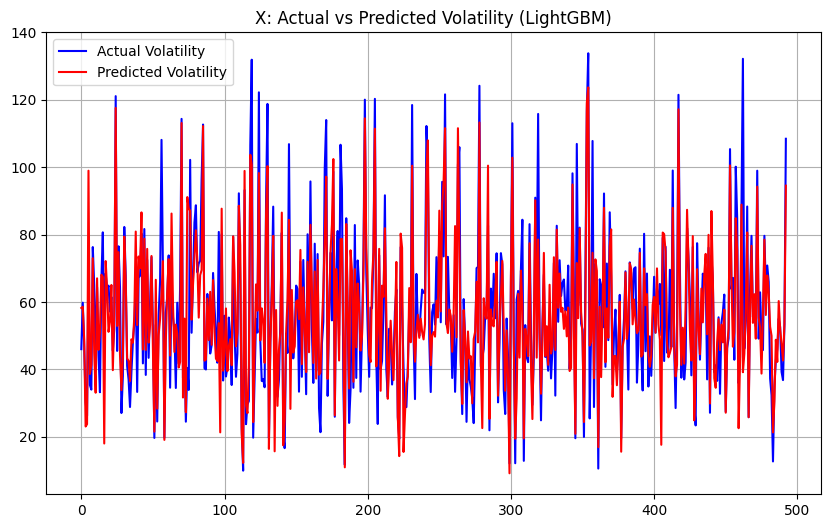


Processing CF...



[*********************100%***********************]  1 of 1 completed


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1968, number of used features: 4
[LightGBM] [Info] Start training from score 38.306210
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves t

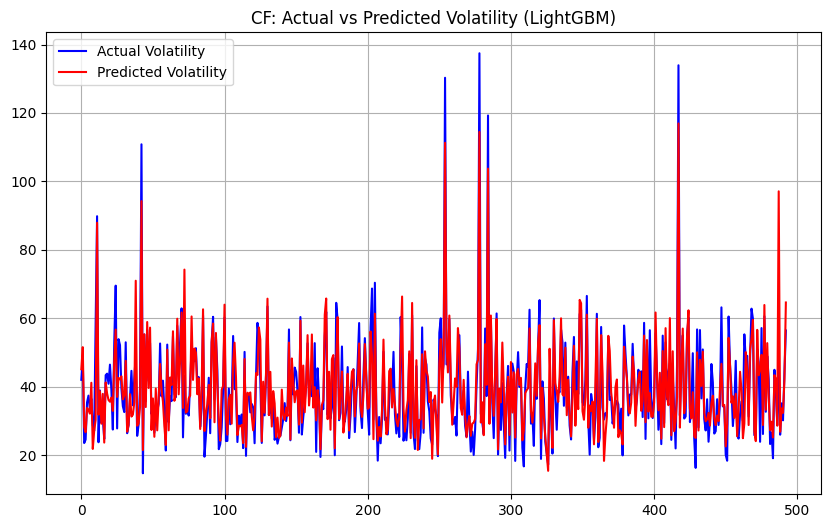

[*********************100%***********************]  1 of 1 completed


Processing VLO...



Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1968, number of used features: 4
[LightGBM] [Info] Start training from score 34.672222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

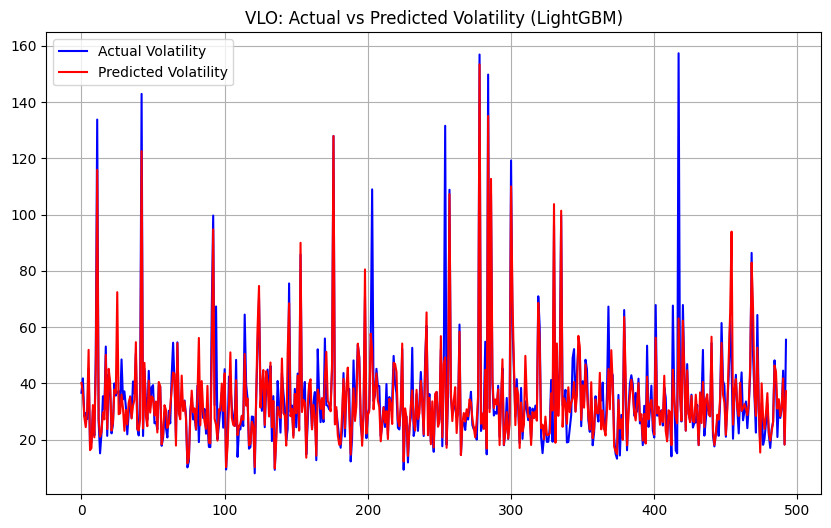

[*********************100%***********************]  1 of 1 completed


Processing TGT...



Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1968, number of used features: 4
[LightGBM] [Info] Start training from score 28.306338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

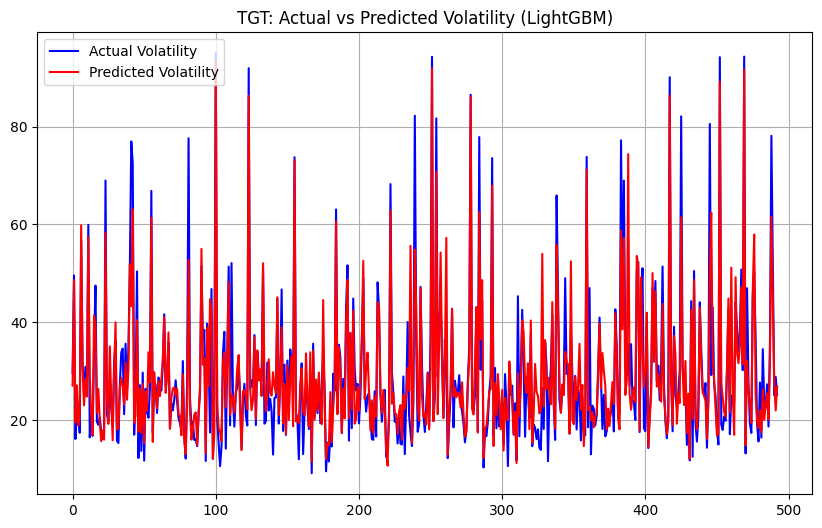

[*********************100%***********************]  1 of 1 completed


Processing DG...



Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1968, number of used features: 4
[LightGBM] [Info] Start training from score 25.899279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

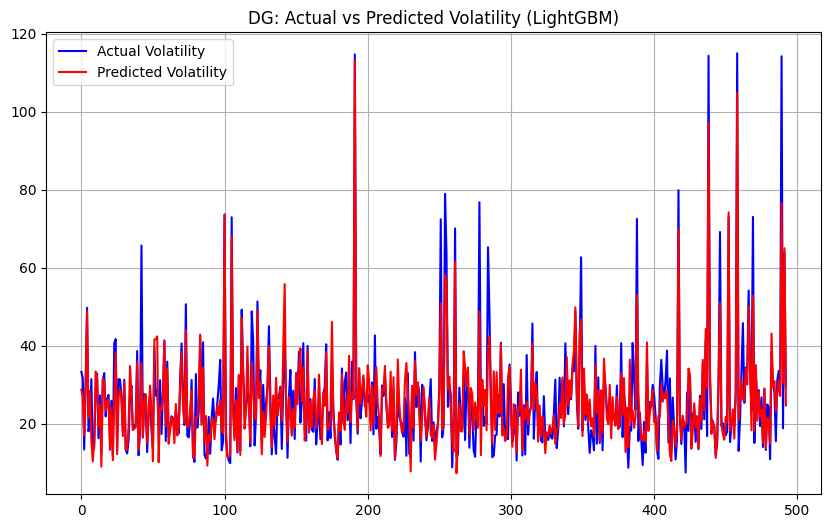


LightGBM + RandomSearch Model Results:
  Ticker       RMSE  Relative RMSE (%)  R_squared  \
3   AAPL   4.220772           4.275901   0.883250   
2     DE   4.695374           4.528075   0.867885   
1    CAT   5.607063           6.088374   0.753856   
0      F   6.547431           5.713254   0.853389   
9     DG   6.688583           6.218193   0.785270   
8    TGT   6.893650           8.030068   0.800272   
6     CF   6.903718           5.621877   0.787572   
7    VLO   9.116452           6.106165   0.788586   
4    WHR  11.534738           7.482538   0.603675   
5      X  12.334876           9.960839   0.724045   

                                         Best_Params  
3  {'subsample': 1.0, 'reg_lambda': 50.0, 'reg_al...  
2  {'subsample': 1.0, 'reg_lambda': 50.0, 'reg_al...  
1  {'subsample': 1.0, 'reg_lambda': 50.0, 'reg_al...  
0  {'subsample': 1.0, 'reg_lambda': 50.0, 'reg_al...  
9  {'subsample': 1.0, 'reg_lambda': 50.0, 'reg_al...  
8  {'subsample': 1.0, 'reg_lambda': 50.0, 'reg

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from ta.momentum import RSIIndicator
from ta.trend import MACD

# List of tickers
tickers = ['F', 'CAT', 'DE', 'AAPL', 'WHR', 'X', 'CF', 'VLO', 'TGT', 'DG']

# Create an empty list to store results
results = []

# Define parameter grid for RandomizedSearchCV (LightGBM version)
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10, 12, -1],  # -1 means no limit in LightGBM
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0, 5.0],   # L1 regularization
    'reg_lambda': [1.0, 10.0, 50.0, 100.0], # L2 regularization
    'min_child_weight': [1, 3, 5, 7],        # Minimum data in a leaf
    'min_split_gain': [0, 0.1, 0.2, 0.3],    # Minimum loss reduction to make a split
}

for ticker in tickers:
    print(f"\nProcessing {ticker}...\n")
    
    # Download historical stock data
    data = yf.download(ticker, start="2015-01-01", end="2025-01-01", group_by="ticker")
    
    # Flatten the multiindex columns
    data.columns = ['_'.join(col).strip() for col in data.columns.values]
    
    # Calculate daily returns
    data['Returns'] = data[f'{ticker}_Close'].pct_change()
    
    # Drop NaN values
    data.dropna(inplace=True)
    
    # Calculate historical volatility (21 days window, annualized and in %)
    window = 21
    data['Volatility'] = data['Returns'].rolling(window=window).std() * np.sqrt(252) * 100
    
    # Feature engineering
    data['MA_21'] = data[f'{ticker}_Close'].rolling(window=21).mean()
    
    rsi = RSIIndicator(close=data[f'{ticker}_Close'], window=14)
    data['RSI'] = rsi.rsi()
    
    macd = MACD(close=data[f'{ticker}_Close'])
    data['MACD'] = macd.macd_diff()
    
    # Rename columns for consistency
    data = data.rename(columns={
        f'{ticker}_Open': 'Open',
        f'{ticker}_High': 'High',
        f'{ticker}_Low': 'Low',
        f'{ticker}_Close': 'Close',
        f'{ticker}_Volume': 'Volume'
    })
    
    # Create target variable: future volatility 21 days ahead
    data['Future_Volatility'] = data['Volatility'].shift(-21)
    
    # Drop remaining NaNs
    data.dropna(inplace=True)
    
    # Features and target
    X = data[['MA_21', 'RSI', 'MACD', 'Volatility']]
    y = data['Future_Volatility']
    
    # Split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Setup LightGBM model
    lgb_model = lgb.LGBMRegressor(random_state=42)
    
    # Setup RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=lgb_model,
        param_distributions=param_grid,
        n_iter=30,  # Try 30 random combinations
        cv=5,
        scoring='r2',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    # Fit random search
    random_search.fit(X_train, y_train)
    
    # Get the best model
    light_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    # Predict
    y_pred = light_model.predict(X_test)
    
    # Plot Actual vs Predicted
    plt.figure(figsize=(10,6))
    plt.plot(y_test.values, label='Actual Volatility', color='blue')
    plt.plot(y_pred, label='Predicted Volatility', color='red')
    plt.title(f'{ticker}: Actual vs Predicted Volatility (LightGBM)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return_range = y_test.max() - y_test.min()
    relative_rmse = rmse / return_range * 100  # percentage

    # Save result for this ticker
    results.append({
        'Ticker': ticker,hu
        'RMSE': rmse,
        'Relative RMSE (%)': relative_rmse,
        'R_squared': r2,
        'Best_Params': best_params
    })

# Convert results to a DataFrame
results_light = pd.DataFrame(results)

# Sort by RMSE if you like
results_light = results_light.sort_values('RMSE')

# Display results
print("\nLightGBM + RandomSearch Model Results:")
print(results_light)


# Testen welke machine learning model het beste is!!!

### Likelihood ratio test:
p-waarde onder de 0.05 betekent dat het tweede model significant beter is dan de eerste.

p-waarde boven de 0.05 betekent dat er geen bewijs is dat het tweede model beter is dan de eerste.

### Algemene ranking op basis van likelihood ratio test

1	LightGBM 

2	Random Forest

3	XGboost	

4	Elastic Net

In [18]:
import numpy as np
from scipy.stats import chi2

# Define the tickers
tickers = ['F', 'CAT', 'DE', 'AAPL', 'WHR', 'X', 'CF', 'VLO', 'TGT', 'DG']

# Extract RMSE values into dictionaries automatically
rmse_elastic = dict(results_elastic[results_elastic['Ticker'].isin(tickers)].set_index('Ticker')['RMSE'])
rmse_rf = dict(results_rf[results_rf['Ticker'].isin(tickers)].set_index('Ticker')['RMSE'])
rmse_xgb = dict(results_XG[results_XG['Ticker'].isin(tickers)].set_index('Ticker')['RMSE'])
rmse_lgb = dict(results_light[results_light['Ticker'].isin(tickers)].set_index('Ticker')['RMSE'])



# Aantal observaties in test set
n = int(0.2 * 252 * 10)  # ongeveer 20% van 3 jaar data (2015-2025)

# Functie om likelihood ratio en p-value te berekenen
def likelihood_ratio_test(rmse1, rmse2):
    var1 = rmse1**2
    var2 = rmse2**2

    logL1 = -n/2 * np.log(2 * np.pi * var1) - n/2
    logL2 = -n/2 * np.log(2 * np.pi * var2) - n/2

    LR_stat = -2 * (logL1 - logL2)
    p_value = chi2.sf(LR_stat, df=1)
    return LR_stat, p_value

# Print alle combinaties
print("\nLikelihood Ratio Tests for Volatility Prediction Models:")
for ticker in tickers:
    print(f"\n{ticker}:")

    # Elastic Net vs Random Forest
    LR_er, p_er = likelihood_ratio_test(rmse_elastic[ticker], rmse_rf[ticker])
    print(f"Elastic Net vs Random Forest: LR = {LR_er:.4f}, p = {p_er:.6f}")
    
    # Elastic Net vs XGBoost
    LR_ex, p_ex = likelihood_ratio_test(rmse_elastic[ticker], rmse_xgb[ticker])
    print(f"Elastic Net vs XGBoost: LR = {LR_ex:.4f}, p = {p_ex:.6f}")

    # Elastic Net vs LightGBM
    LR_elgb, p_elgb = likelihood_ratio_test(rmse_elastic[ticker], rmse_lgb[ticker])
    print(f"Elastic Net vs LightGBM: LR = {LR_elgb:.4f}, p = {p_elgb:.6f}")
    
    # Random Forest vs XGBoost
    LR_rx, p_rx = likelihood_ratio_test(rmse_rf[ticker], rmse_xgb[ticker])
    print(f"Random Forest vs XGBoost: LR = {LR_rx:.4f}, p = {p_rx:.6f}")
    
    # Random Forest vs LightGBM
    LR_rlgb, p_rlgb = likelihood_ratio_test(rmse_rf[ticker], rmse_lgb[ticker])
    print(f"Random Forest vs LightGBM: LR = {LR_rlgb:.4f}, p = {p_rlgb:.6f}")
    
    # XGBoost vs LightGBM
    LR_xlgb, p_xlgb = likelihood_ratio_test(rmse_xgb[ticker], rmse_lgb[ticker])
    print(f"XGBoost vs LightGBM: LR = {LR_xlgb:.4f}, p = {p_xlgb:.6f}")



Likelihood Ratio Tests for Volatility Prediction Models:

F:
Elastic Net vs Random Forest: LR = 808.2552, p = 0.000000
Elastic Net vs XGBoost: LR = 470.2647, p = 0.000000
Elastic Net vs LightGBM: LR = 801.1684, p = 0.000000
Random Forest vs XGBoost: LR = -337.9905, p = 1.000000
Random Forest vs LightGBM: LR = -7.0869, p = 1.000000
XGBoost vs LightGBM: LR = 330.9036, p = 0.000000

CAT:
Elastic Net vs Random Forest: LR = 612.4722, p = 0.000000
Elastic Net vs XGBoost: LR = 248.3257, p = 0.000000
Elastic Net vs LightGBM: LR = 544.3785, p = 0.000000
Random Forest vs XGBoost: LR = -364.1465, p = 1.000000
Random Forest vs LightGBM: LR = -68.0937, p = 1.000000
XGBoost vs LightGBM: LR = 296.0528, p = 0.000000

DE:
Elastic Net vs Random Forest: LR = 782.1210, p = 0.000000
Elastic Net vs XGBoost: LR = 499.8238, p = 0.000000
Elastic Net vs LightGBM: LR = 882.9845, p = 0.000000
Random Forest vs XGBoost: LR = -282.2972, p = 1.000000
Random Forest vs LightGBM: LR = 100.8636, p = 0.000000
XGBoost vs 

### Op basis van grafieken

1	LightGBM - Beste RMSE en Relative RMSE, bijna even goed als Random Forest in R².

2	Random Forest -	Top in R², zeer dicht bij LightGBM in RMSE, iets minder stabiel.

3	XGBoost - Duidelijk slechter dan LightGBM en Random Forest.

4	Elastic Net -	Overal veel slechter, slechtste RMSE en R².

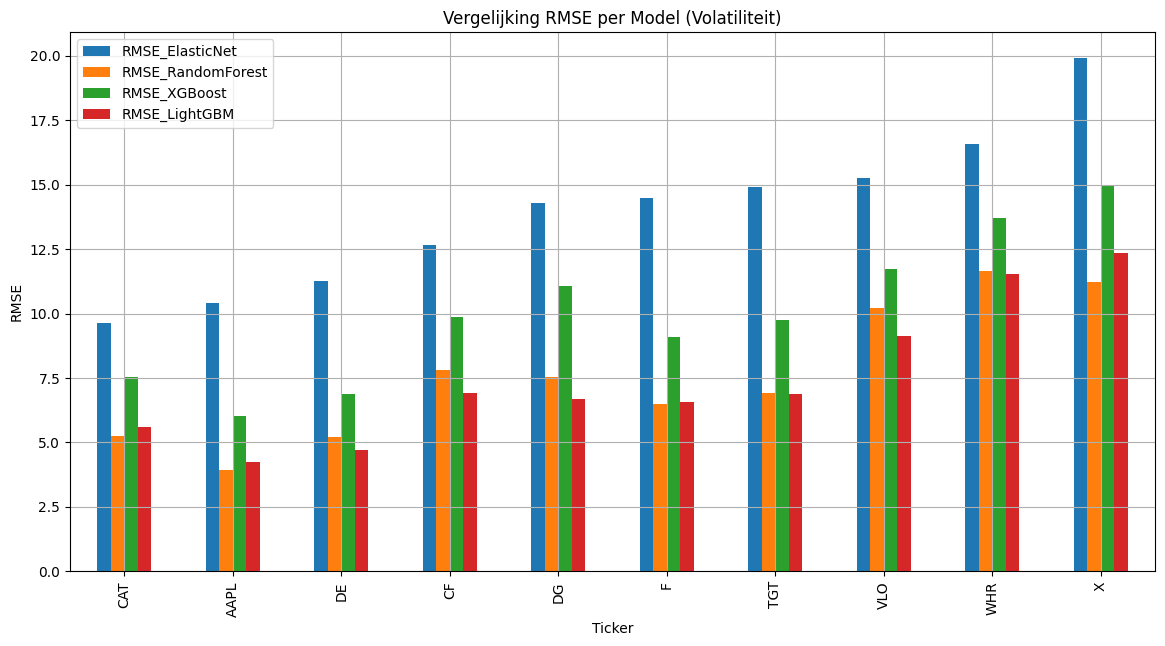

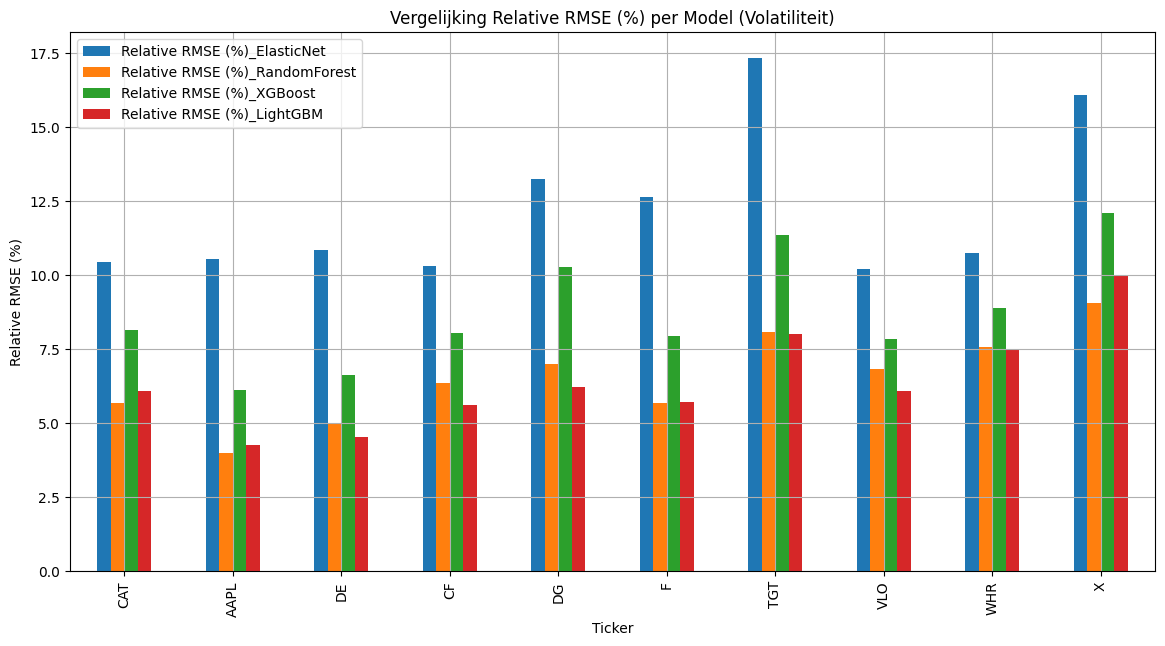

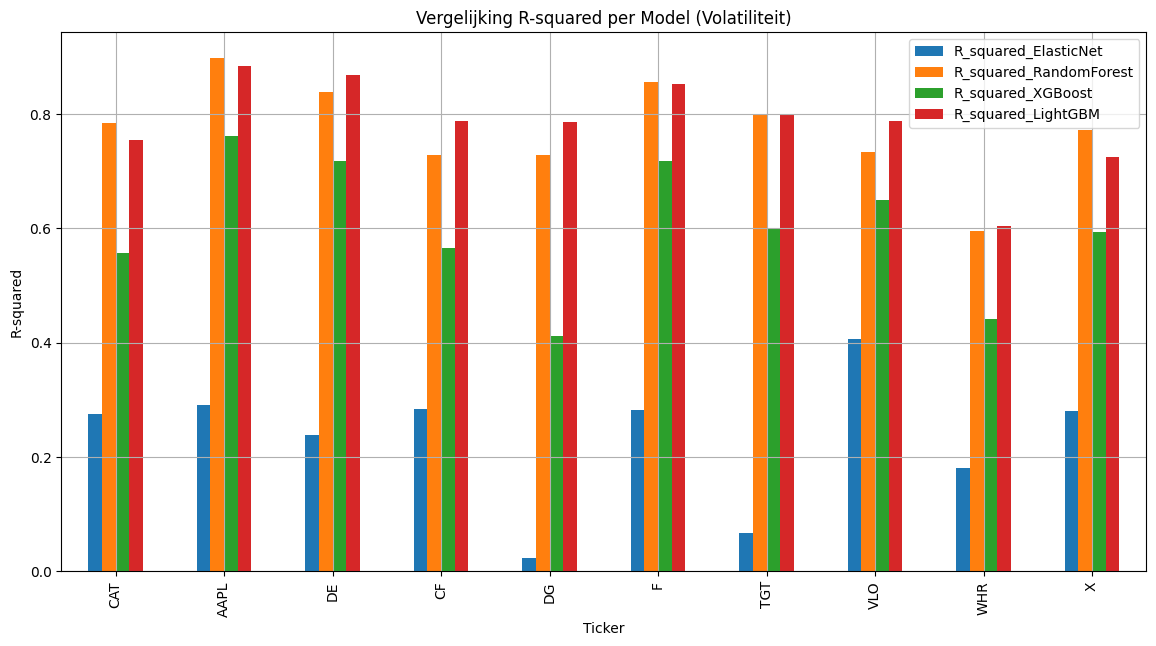


Vergelijking Elastic Net vs Random Forest vs XGBoost vs LightGBM (Volatiliteit):
  Ticker  RMSE_ElasticNet  Relative RMSE (%)_ElasticNet  R_squared_ElasticNet  \
0    CAT         9.622317                     10.448299              0.275101   
1   AAPL        10.406225                     10.542144              0.290327   
2     DE        11.274624                     10.872902              0.238242   
3     CF        12.672649                     10.319667              0.284220   
4     DG        14.272454                     13.268711              0.022266   
5      F        14.496144                     12.649258              0.281329   
6    TGT        14.893604                     17.348814              0.067732   
7    VLO        15.265432                     10.224730              0.407211   
8    WHR        16.580050                     10.755412              0.181144   
9      X        19.918161                     16.084605              0.280440   

                          

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Select the tickers you are interested in
# Define the tickers
tickers = ['F', 'CAT', 'DE', 'AAPL', 'WHR', 'X', 'CF', 'VLO', 'TGT', 'DG']

# Step 2: Filter each model's results for these tickers

# Elastic Net results
results_elastic_net = results_elastic[results_elastic['Ticker'].isin(tickers)].reset_index(drop=True)

# Random Forest results
results_random_forest = results_rf[results_rf['Ticker'].isin(tickers)].reset_index(drop=True)

# XGBoost results
results_xgboost = results_XG[results_XG['Ticker'].isin(tickers)].reset_index(drop=True)

# LightGBM results
results_lightgbm = results_light[results_light['Ticker'].isin(tickers)].reset_index(drop=True)


# Zet alles in dataframes
df_elastic_vol = pd.DataFrame(results_elastic_net)
df_rf_vol = pd.DataFrame(results_random_forest)
df_xgb_vol = pd.DataFrame(results_xgboost)
df_lgb_vol = pd.DataFrame(results_lightgbm)

# Merge op Ticker
comparison_vol = df_elastic_vol.merge(df_rf_vol, on='Ticker', suffixes=('_ElasticNet', '_RandomForest'))
comparison_vol = comparison_vol.merge(df_xgb_vol, on='Ticker')
comparison_vol = comparison_vol.rename(columns={
    'RMSE': 'RMSE_XGBoost',
    'Relative RMSE (%)': 'Relative RMSE (%)_XGBoost',
    'R_squared': 'R_squared_XGBoost'
})
comparison_vol = comparison_vol.merge(df_lgb_vol, on='Ticker')
comparison_vol = comparison_vol.rename(columns={
    'RMSE': 'RMSE_LightGBM',
    'Relative RMSE (%)': 'Relative RMSE (%)_LightGBM',
    'R_squared': 'R_squared_LightGBM'
})

# ------------------
# Barplots
# ------------------

# RMSE Vergelijking
comparison_vol.plot(x='Ticker', y=[
    'RMSE_ElasticNet', 'RMSE_RandomForest', 'RMSE_XGBoost', 'RMSE_LightGBM'
], kind='bar', figsize=(14,7))
plt.title('Vergelijking RMSE per Model (Volatiliteit)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

# Relative RMSE Vergelijking
comparison_vol.plot(x='Ticker', y=[
    'Relative RMSE (%)_ElasticNet', 'Relative RMSE (%)_RandomForest',
    'Relative RMSE (%)_XGBoost', 'Relative RMSE (%)_LightGBM'
], kind='bar', figsize=(14,7))
plt.title('Vergelijking Relative RMSE (%) per Model (Volatiliteit)')
plt.ylabel('Relative RMSE (%)')
plt.grid(True)
plt.show()

# R-squared Vergelijking
comparison_vol.plot(x='Ticker', y=[
    'R_squared_ElasticNet', 'R_squared_RandomForest', 'R_squared_XGBoost', 'R_squared_LightGBM'
], kind='bar', figsize=(14,7))
plt.title('Vergelijking R-squared per Model (Volatiliteit)')
plt.ylabel('R-squared')
plt.grid(True)
plt.show()

# ------------------
# Print comparison table
# ------------------
print("\nVergelijking Elastic Net vs Random Forest vs XGBoost vs LightGBM (Volatiliteit):")
print(comparison_vol)


# Kijken naar overfitting en onderfitting


Training RMSE: 14.3496
Test RMSE: 14.2725
Training R²: 0.0388
Test R²: 0.0223
Model seems to generalize well between training and test sets.
Cross-Validation RMSE: 14.3159 ± 1.5497


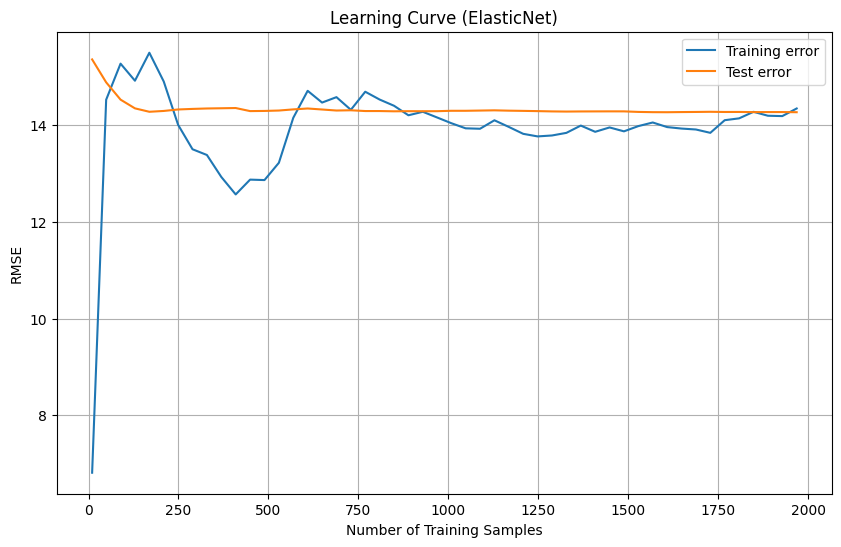


Tuning alpha regularization:
Alpha: 0.001 -> Test RMSE: 14.2711
Alpha: 0.01 -> Test RMSE: 14.2712
Alpha: 0.1 -> Test RMSE: 14.2724
Alpha: 1.0 -> Test RMSE: 14.2745
Alpha: 10.0 -> Test RMSE: 14.2542


In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import ElasticNet

# Function to check for overfitting for ElasticNet
def check_overfitting_elasticnet(model, X_train, y_train, X_test, y_test, cv=5):
    # 1. Check Training vs Test Performance
    model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    if train_rmse < test_rmse:
        print("Potential overfitting: Training RMSE is lower than Test RMSE.")
    else:
        print("Model seems to generalize well between training and test sets.")
    
    # 2. Cross-validation performance
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    print(f"Cross-Validation RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
    
    # 3. Learning curves
    train_errors, test_errors = [], []
    sample_points = np.linspace(10, len(X_train), 50, dtype=int)
    for m in sample_points:
        temp_model = ElasticNet(alpha=model.alpha, l1_ratio=model.l1_ratio, random_state=42, max_iter=50000)
        temp_model.fit(X_train[:m], y_train[:m])
        train_errors.append(mean_squared_error(y_train[:m], temp_model.predict(X_train[:m]), squared=False))
        test_errors.append(mean_squared_error(y_test, temp_model.predict(X_test), squared=False))
    
    plt.figure(figsize=(10, 6))
    plt.plot(sample_points, train_errors, label="Training error")
    plt.plot(sample_points, test_errors, label="Test error")
    plt.title("Learning Curve (ElasticNet)")
    plt.xlabel("Number of Training Samples")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 4. Try Regularization
    print("\nTuning alpha regularization:")
    for alpha in [0.001, 0.01, 0.1, 1.0, 10.0]:
        temp_model = ElasticNet(alpha=alpha, l1_ratio=model.l1_ratio, random_state=42, max_iter=50000)
        temp_model.fit(X_train, y_train)
        y_test_pred = temp_model.predict(X_test)
        test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
        print(f"Alpha: {alpha} -> Test RMSE: {test_rmse:.4f}")

# Example usage:
check_overfitting_elasticnet(elastic_model, X_train, y_train, X_test, y_test)


Training RMSE: 2.6225
Test RMSE: 7.5326
Training R²: 0.9679
Test R²: 0.7277
Potential overfitting: Training RMSE is lower than Test RMSE.
Cross-Validation RMSE: 7.2080 ± 0.5052


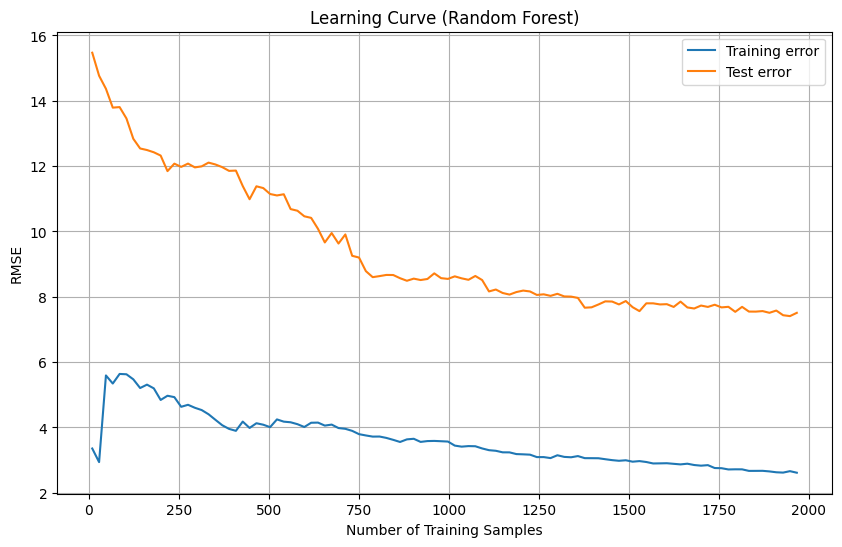


Tuning max_depth parameter:
Max Depth: 3 -> Test RMSE: 13.5364
Max Depth: 5 -> Test RMSE: 11.4391
Max Depth: 7 -> Test RMSE: 9.4664
Max Depth: 10 -> Test RMSE: 8.1109
Max Depth: None -> Test RMSE: 7.5326


In [21]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Function to check for overfitting (Random Forest version)
def check_overfitting_rf(model, X_train, y_train, X_test, y_test, cv=5):
    # 1. Check Training vs Test Performance
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    if train_rmse < test_rmse:
        print("Potential overfitting: Training RMSE is lower than Test RMSE.")
    else:
        print("Model seems to generalize well between training and test sets.")
    
    # 2. Check Cross-validation Performance
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    print(f"Cross-Validation RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
    
    # 3. Plot Learning Curves
    train_errors, test_errors = [], []
    for m in range(10, len(X_train), max(1, len(X_train)//100)):
        model.fit(X_train[:m], y_train[:m])
        train_errors.append(mean_squared_error(y_train[:m], model.predict(X_train[:m]), squared=False))
        test_errors.append(mean_squared_error(y_test, model.predict(X_test), squared=False))
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(10, len(X_train), max(1, len(X_train)//100)), train_errors, label="Training error")
    plt.plot(np.arange(10, len(X_train), max(1, len(X_train)//100)), test_errors, label="Test error")
    plt.title("Learning Curve (Random Forest)")
    plt.xlabel("Number of Training Samples")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Try Simplifying the Trees (Regularization in RF)
    print("\nTuning max_depth parameter:")
    for depth in [3, 5, 7, 10, None]:
        model.set_params(max_depth=depth)
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
        print(f"Max Depth: {depth} -> Test RMSE: {test_rmse:.4f}")

# Example call:
check_overfitting_rf(rf_model, X_train, y_train, X_test, y_test)


Training RMSE: 8.8691
Test RMSE: 11.0256
Training R²: 0.6328
Test R²: 0.4165
Potential overfitting: Training RMSE is lower than Test RMSE.
Cross-Validation RMSE: 10.4513 ± 0.7553


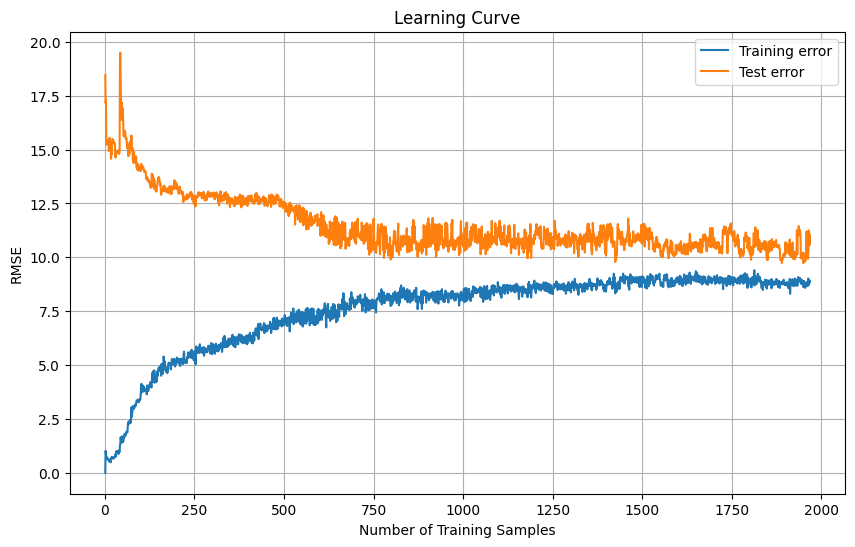


Tuning regularization parameters:
Alpha: 0.01 -> Test RMSE: 11.0706
Alpha: 0.1 -> Test RMSE: 11.0711
Alpha: 0.5 -> Test RMSE: 10.9983
Alpha: 1.0 -> Test RMSE: 11.0256


In [22]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Function to check for overfitting
def check_overfitting(model, X_train, y_train, X_test, y_test, cv=5):
    # 1. Check Training vs Test Performance
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics (RMSE and R^2) on both training and test data
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    if train_rmse < test_rmse:
        print("Potential overfitting: Training RMSE is lower than Test RMSE.")
    else:
        print("Model seems to generalize well between training and test sets.")
    
    # 2. Check Cross-validation Performance
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    print(f"Cross-Validation RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
    
    # 3. Plot Learning Curves
    train_errors, test_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        train_errors.append(mean_squared_error(y_train[:m], model.predict(X_train[:m]), squared=False))
        test_errors.append(mean_squared_error(y_test, model.predict(X_test), squared=False))
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(X_train) + 1), train_errors, label="Training error")
    plt.plot(np.arange(1, len(X_train) + 1), test_errors, label="Test error")
    plt.title("Learning Curve")
    plt.xlabel("Number of Training Samples")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Try Regularization (if needed)
    print("\nTuning regularization parameters:")
    for alpha in [0.01, 0.1, 0.5, 1.0]:
        model.set_params(reg_alpha=alpha)
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
        print(f"Alpha: {alpha} -> Test RMSE: {test_rmse:.4f}")

# Example: Call the function with your model and data
# Assuming `best_model` is the trained XGBoost model and X_train, X_test, y_train, y_test are your data splits
check_overfitting(XG_model, X_train, y_train, X_test, y_test)


Training RMSE: 2.3992
Test RMSE: 6.6886
Training R²: 0.9731
Test R²: 0.7853
Potential overfitting: Training RMSE is lower than Test RMSE.
Cross-Validation RMSE: 6.8627 ± 0.3407


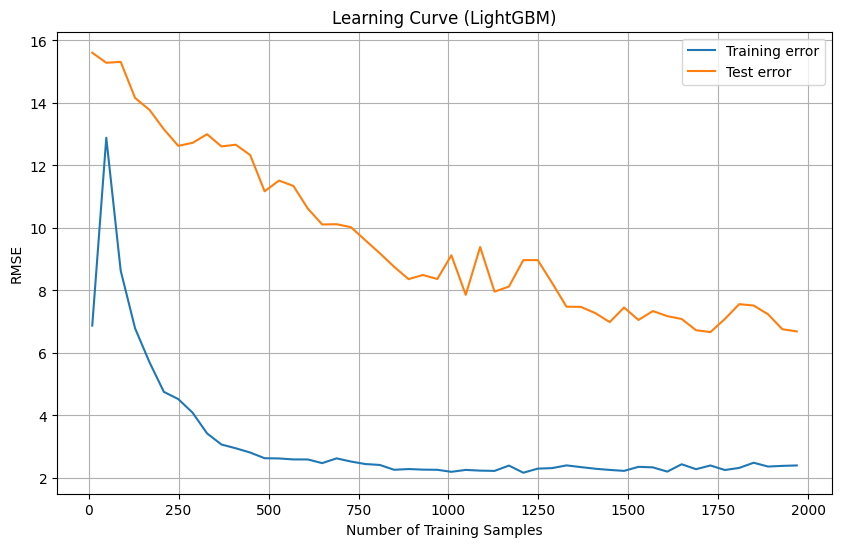


Tuning reg_alpha regularization:
reg_alpha: 0 -> Test RMSE: 6.3806
reg_alpha: 0.1 -> Test RMSE: 6.4900
reg_alpha: 0.5 -> Test RMSE: 6.4707
reg_alpha: 1.0 -> Test RMSE: 6.4585
reg_alpha: 5.0 -> Test RMSE: 6.6886


In [23]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import lightgbm as lgb

# Function to check overfitting for LightGBM
def check_overfitting_lgbm(model, X_train, y_train, X_test, y_test, cv=5):
    # 1. Fit the model
    model.set_params(verbose=-1)  # suppress warnings globally
    model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    if train_rmse < test_rmse:
        print("Potential overfitting: Training RMSE is lower than Test RMSE.")
    else:
        print("Model generalizes well between training and test sets.")
    
    # 2. Cross-validation performance
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    print(f"Cross-Validation RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
    
    # 3. Learning Curve
    train_errors, test_errors = [], []
    sample_points = np.linspace(10, len(X_train), 50, dtype=int)
    for m in sample_points:
        temp_model = lgb.LGBMRegressor(**model.get_params())
        temp_model.set_params(verbose=-1)  # suppress warnings
        temp_model.fit(X_train[:m], y_train[:m])
        train_errors.append(mean_squared_error(y_train[:m], temp_model.predict(X_train[:m]), squared=False))
        test_errors.append(mean_squared_error(y_test, temp_model.predict(X_test), squared=False))
    
    plt.figure(figsize=(10, 6))
    plt.plot(sample_points, train_errors, label="Training error")
    plt.plot(sample_points, test_errors, label="Test error")
    plt.title("Learning Curve (LightGBM)")
    plt.xlabel("Number of Training Samples")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 4. Test Regularization
    print("\nTuning reg_alpha regularization:")
    for alpha in [0, 0.1, 0.5, 1.0, 5.0]:
        temp_model = lgb.LGBMRegressor(**model.get_params())
        temp_model.set_params(reg_alpha=alpha, verbose=-1)  # suppress warnings
        temp_model.fit(X_train, y_train)
        y_test_pred = temp_model.predict(X_test)
        test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
        print(f"reg_alpha: {alpha} -> Test RMSE: {test_rmse:.4f}")

# Example usage:
check_overfitting_lgbm(light_model, X_train, y_train, X_test, y_test)


# Kijken naar Shap Values en Feature importance!

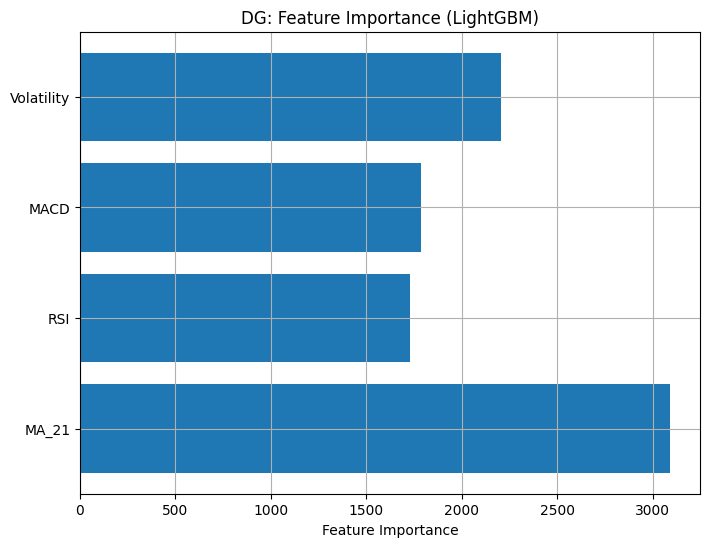

In [24]:
# Feature Importance (LightGBM ingebouwd)
importances = light_model.feature_importances_
feature_names = X_train.columns

# Plot
plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title(f'{ticker}: Feature Importance (LightGBM)')
plt.grid(True)
plt.show()


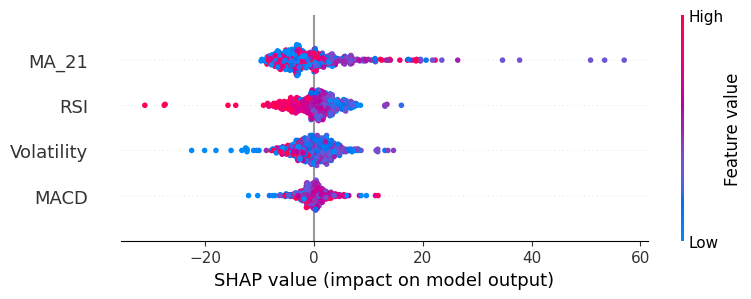

In [ ]:
import shap

# Maak explainer voor jouw getrainde LightGBM model
explainer = shap.Explainer(light_model)

# Bereken SHAP-waarden voor de testset
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test, show=False)
plt.savefig(f"{ticker}_shap_summary.png", bbox_inches='tight')


